In [1]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install st-dbscan

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install mgwr

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install networkit

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from time import sleep
import geopandas as gpd
from shapely.geometry import Point, box
from shapely.ops import nearest_points
from geopy.geocoders import Nominatim
import osmnx as ox
import networkx as nx
import networkit as nk
from scipy.spatial import KDTree, cKDTree
from st_dbscan import ST_DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from scipy.stats import ttest_ind, pearsonr, spearmanr, mannwhitneyu, randint
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    f1_score, precision_recall_curve,
    classification_report, confusion_matrix, roc_auc_score
)
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR
from mgwr.utils import shift_colormap

In [7]:
# loading accidents data
df = pd.read_csv("Accidents.csv", dtype={"accident_index": str, "accident_reference": str})

In [8]:
print(df.columns)

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location',
       'enhanced_severity_collision'],
      dtype='object')


In [9]:
df.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2019010128300           2019          010128300               528218.0   
1  2019010152270           2019          010152270               530219.0   
2  2019010155191           2019          010155191               530222.0   
3  2019010155192           2019          010155192               525531.0   
4  2019010155194           2019          010155194               524920.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                180407.0  -0.153842  51.508057             1   
1                172463.0  -0.127949  51.436208             1   
2                182543.0  -0.124193  51.526795             1   
3                184605.0  -0.191044  51.546387             1   
4                184004.0  -0.200064  51.541121             1   

   accident_severity  number_of_vehicles  ...  light_conditions  \
0                  3                   2  ...                 1   
1                  3                   2  ...                 4   
2                  3                   2  ...                 4   
3                  2                   1  ...                 4   
4                  3                   2  ...                 4   

  weather_conditions  road_surface_conditions special_conditions_at_site  \
0                  1                        1                          0   
1                  1                        1                          0   
2                  1                        1                          0   
3                  1                        1                          0   
4                  1                        1                          0   

   carriageway_hazards urban_or_rural_area  \
0                    0                   1   
1                    0                   1   
2                    0                   1   
3                    0                   1   
4                    0                   1   

  did_police_officer_attend_scene_of_accident  trunk_road_flag  \
0                                           3                2   
1                                           3                2   
2                                           1                2   
3                                           1                2   
4                                           1                2   

   lsoa_of_accident_location  enhanced_severity_collision  
0                  E01004762                           -1  
1                  E01003117                           -1  
2                  E01000943                           -1  
3                  E01000973                           -1  
4                  E01000546                           -1  

[5 rows x 37 columns]

In [10]:
df["local_authority_ons_district"].head()

0    E09000033
1    E09000022
2    E09000007
3    E09000007
4    E09000005
Name: local_authority_ons_district, dtype: object

In [11]:
# filtering accidents data for manchester and birmingham
ons_codes = ["E08000003", "E08000025"]
df = df[df["local_authority_ons_district"].isin(ons_codes)]

In [12]:
# identifying rows with missing date and time
missing_date_rows = df[df["date"].isna()]
missing_time_rows = df[df["time"].isna()]
print(len(missing_date_rows))
print(len(missing_time_rows))

0
0


In [13]:
# checking for wrong time strings
correct_time_strings = df["time"].dropna().str.match(r"^\d{2}:\d{2}$", na=False)
wrong_time_strings = (~correct_time_strings).sum()
print(wrong_time_strings)

0


In [17]:
print(df[["date", "time"]].head())

             date   time
31179  11/03/2019  21:12
31183  08/01/2019  17:15
31184  17/01/2019  09:05
31185  10/01/2019  18:29
31186  16/01/2019  18:43


In [19]:
# combining date and time and create a new columnn
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="%d/%m/%Y %H:%M", errors="coerce")

In [21]:
print(df["datetime"].head())

31179   2019-03-11 21:12:00
31183   2019-01-08 17:15:00
31184   2019-01-17 09:05:00
31185   2019-01-10 18:29:00
31186   2019-01-16 18:43:00
Name: datetime, dtype: datetime64[ns]


In [23]:
# checking for failed parsing
nat_rows = df[df["datetime"].isna()]
print(len(nat_rows))

0


In [25]:
# check if there is correct date and time format
df["day"] = df["datetime"].dt.day
df["month"] = df["datetime"].dt.month
df["hour"] = df["datetime"].dt.hour
print(df[["date", "datetime", "day", "month"]].head(10))
print("Min datetime:", df["datetime"].min())
print("Max datetime:", df["datetime"].max())

             date            datetime  day  month
31179  11/03/2019 2019-03-11 21:12:00   11      3
31183  08/01/2019 2019-01-08 17:15:00    8      1
31184  17/01/2019 2019-01-17 09:05:00   17      1
31185  10/01/2019 2019-01-10 18:29:00   10      1
31186  16/01/2019 2019-01-16 18:43:00   16      1
31187  15/01/2019 2019-01-15 12:00:00   15      1
31188  02/02/2019 2019-02-02 16:30:00    2      2
31189  17/02/2019 2019-02-17 12:30:00   17      2
31190  19/02/2019 2019-02-19 09:15:00   19      2
31191  19/02/2019 2019-02-19 14:15:00   19      2
Min datetime: 2019-01-01 04:28:00
Max datetime: 2023-12-31 16:43:00


In [27]:
# dropping columns that are not needed
drop_columns = [
    'accident_reference',
    'accident_number',
    'second_road_number',
    'did_police_officer_attend_scene_of_accident',
    'enhanced_local_authority',
    'enhanced_severity_collision'
]
df = df.drop(columns=[col for col in drop_columns if col in df.columns])

In [29]:
# checking if any variables has missing data
df.isnull().sum().sort_values(ascending=False)

accident_index                             0
speed_limit                                0
junction_control                           0
second_road_class                          0
pedestrian_crossing_human_control          0
pedestrian_crossing_physical_facilities    0
light_conditions                           0
weather_conditions                         0
road_surface_conditions                    0
special_conditions_at_site                 0
carriageway_hazards                        0
urban_or_rural_area                        0
trunk_road_flag                            0
lsoa_of_accident_location                  0
datetime                                   0
day                                        0
month                                      0
junction_detail                            0
road_type                                  0
accident_year                              0
first_road_number                          0
location_easting_osgr                      0
location_n

In [31]:
# mapping ons codes to both the cities
ons_city = {
    "E08000003": "Manchester",
    "E08000025": "Birmingham"
}
df["city"] = df["local_authority_ons_district"].map(ons_city)

In [33]:
# loading and combining weather data
weather_man = pd.read_csv("weather_manchester.csv")
weather_bir = pd.read_csv("weather_birmingham.csv")
weather_man["city"] = "Manchester"
weather_bir["city"] = "Birmingham"
weather_data = pd.concat([weather_man, weather_bir], ignore_index=True)

In [35]:
# aligning accidents data and weather data by nearest hour
df["datetime"] = df["datetime"].dt.floor("H")
weather_data["datetime"] = pd.to_datetime(weather_data["datetime"], dayfirst=True)

In [37]:
# merging accidents data and weather data
merged_data = pd.merge(
    df,
    weather_data,
    how="left",
    on=["city", "datetime"]
)

In [39]:
# defining weather columns
weather_cols = [
    "temperature_2m", "precipitation", "snowfall", "wind_speed_10m",
    "cloud_cover_low", "relative_humidity_2m"
]

In [41]:
# flagging and check missing weather data
merged_data["missing_weather_data"] = merged_data[weather_cols].isnull().any(axis=1)
missing = merged_data["missing_weather_data"].sum()
print(missing)

0


In [43]:
# checking if any variables has missing data
merged_data.isnull().sum().sort_values(ascending=False)

accident_index                             0
city                                       0
road_surface_conditions                    0
special_conditions_at_site                 0
carriageway_hazards                        0
urban_or_rural_area                        0
trunk_road_flag                            0
lsoa_of_accident_location                  0
datetime                                   0
day                                        0
month                                      0
hour                                       0
temperature_2m                             0
accident_year                              0
dew_point_2m                               0
precipitation                              0
snowfall                                   0
snow_depth                                 0
cloud_cover_low                            0
wind_speed_10m                             0
wind_gusts_10m                             0
wind_direction_10m                         0
relative_h

In [47]:
accidents_data = df

In [49]:
# converting accidents data to geodataframe
geo_accidents = gpd.GeoDataFrame(
    accidents_data,
    geometry=gpd.points_from_xy(accidents_data.longitude, accidents_data.latitude),
    crs="EPSG:4326"
)

In [51]:
# loading lsoa data
geo_lsoa = gpd.read_file("LSOA/LSOA_2021_EW_BGC_V5.shp")

In [52]:
# filtering lsoa data for manchester and birmingham
geo_lsoa = geo_lsoa[geo_lsoa["LSOA21NM"].str.contains("Manchester|Birmingham", case=False)]

In [55]:
# checking crs
print(geo_accidents.crs)
print(geo_lsoa.crs)

EPSG:4326
EPSG:27700


In [57]:
# checking geometry invalidity
invalid_data = geo_accidents[~geo_accidents.is_valid]
print(len(invalid_data))

0


In [59]:
# checking for missing coordinates
missing_coordinates = geo_accidents[geo_accidents.geometry.is_empty | geo_accidents.geometry.isna()]
print(len(missing_coordinates))

0


In [61]:
# reprojecting crs of accidents data to the same as LSOA
geo_accidents = geo_accidents.to_crs(geo_lsoa.crs)

In [63]:
# spatial join
accidents_lsoa = gpd.sjoin(
    geo_accidents,
    geo_lsoa[["LSOA21CD", "geometry"]],
    how="left",
    predicate="intersects"
)

In [65]:
# counting unmatched data
total_accidents = len(accidents_lsoa)
unmatched_data = accidents_lsoa["LSOA21CD"].isna().sum()
matched_data = total_accidents - unmatched_data
print(matched_data)
print(unmatched_data)

14606
36


In [67]:
# dropping unmatched data
accidents_lsoa = accidents_lsoa[accidents_lsoa["LSOA21CD"].notna()]

In [69]:
# aggregating accidents data with accident count and average severity
accidents_agg= accidents_lsoa.groupby("LSOA21CD").agg(
    accident_count=("accident_severity", "count"),
    avg_severity=("accident_severity", "mean")
).reset_index()

In [71]:
# merging the aggreagted data with lsoa 
lsoa_with_accidents = geo_lsoa.merge(accidents_agg, on="LSOA21CD", how="left")

In [73]:
# checking for missing values
total_lsoas = len(lsoa_with_accidents)
print(total_lsoas)
print(lsoa_with_accidents["accident_count"].isna().sum())
print(lsoa_with_accidents["avg_severity"].isna().sum())

954
10
10


In [75]:
# filling missing values
lsoa_with_accidents["accident_count"] = lsoa_with_accidents["accident_count"].fillna(0).astype(int)
lsoa_with_accidents["avg_severity"] = lsoa_with_accidents["avg_severity"].fillna(0)

In [77]:
# loading road network with OSMNX
man_roads = ox.graph_from_place("Manchester, UK", network_type="drive")
bir_roads = ox.graph_from_place("Birmingham, UK", network_type="drive")

In [78]:
# converting road network to geodataframe
gdf_man_roads = ox.graph_to_gdfs(man_roads, nodes=False, edges=True)
gdf_bir_roads = ox.graph_to_gdfs(bir_roads, nodes=False, edges=True)

In [79]:
# merging road networks of manchester and birmingham
gdf_roads = pd.concat([gdf_man_roads, gdf_bir_roads])

In [80]:
gdf_roads = gdf_roads.to_crs(epsg=27700)
lsoa_with_accidents = lsoa_with_accidents.to_crs(epsg=27700)

In [81]:
# splitting road networks by LSOA boundaries
gdf_roads_LSOA = gpd.overlay(
    gdf_roads,
    lsoa_with_accidents[["LSOA21CD", "geometry"]],
    how="intersection"
)

In [82]:
# computing road length 
gdf_roads_LSOA["road_length"] = gdf_roads_LSOA.geometry.length
# aggregating road length by LSOA
road_length_by_lsoa = gdf_roads_LSOA.groupby("LSOA21CD")["road_length"].sum().reset_index()

In [83]:
# merging road network data and lsoa data
lsoa_road_merged = lsoa_with_accidents.merge(road_length_by_lsoa, on="LSOA21CD", how="left")

In [84]:
# checking LSOAs with zero road length
print((lsoa_road_merged["road_length"] == 0).sum())

0


In [85]:
print(lsoa_road_merged["road_length"].describe())

count      954.000000
mean      8034.053709
std       3775.049826
min        710.587395
25%       5814.760040
50%       7354.068840
75%       9238.619953
max      39400.289404
Name: road_length, dtype: float64


In [87]:
# loading aadf data
aadf = pd.read_csv("AADF_traffic_counts.csv", low_memory=False)

In [88]:
# filtering aadf to years 2019-2023
aadf_filtered = aadf[aadf["year"].between(2019, 2023)].copy()

In [89]:
# converting aadf data to geodataframe
gdf_aadf = gpd.GeoDataFrame(
    aadf_filtered,
    geometry=gpd.points_from_xy(aadf_filtered.longitude, aadf_filtered.latitude),
    crs="EPSG:4326"
)

In [90]:
# filtering the geodataframe to manchester and birmingham
gdf_aadf = gdf_aadf[
    gdf_aadf["local_authority_name"].str.contains("Manchester|Birmingham", case=False, na=False)
]

In [91]:
gdf_aadf = gdf_aadf.to_crs(epsg=27700)
gdf_roads = gdf_roads.to_crs(epsg=27700)
lsoa_road_merged = lsoa_road_merged.to_crs(epsg=27700)

In [112]:
# spatial join of aadf and lsoa
aadf_on_roads = gpd.sjoin_nearest(
    gdf_aadf,
    gdf_roads[gdf_roads["highway"].isin(["motorway", "primary", "secondary", "tertiary", "residential"])],
    how="left",
    max_distance=30,
    distance_col="distance_to_road"
)

In [114]:
# computing length of road segments
aadf_on_roads["segment_length"] = aadf_on_roads.geometry.length
aadf_lsoa = gpd.sjoin(
    aadf_on_roads,
    lsoa_road_merged[["LSOA21CD", "geometry"]],
    how="left"
)

In [116]:
# computing average daily traffic
aadf_per_lsoa = aadf_lsoa.groupby("LSOA21CD")["all_motor_vehicles"].mean().reset_index()
aadf_per_lsoa.rename(columns={"all_motor_vehicles": "avg_daily_traffic"}, inplace=True)

In [118]:
# merging aadf data with lsoa data
final_data = lsoa_road_merged.merge(aadf_per_lsoa, on="LSOA21CD", how="left")

In [120]:
# idw imputation of avg_daily_traffic
final_data["has_traffic"] = final_data["avg_daily_traffic"].notna()
final_data["centroid"] = final_data.geometry.centroid
known = final_data[final_data["has_traffic"]]
unknown = final_data[~final_data["has_traffic"]]
known_coords = np.vstack([known["centroid"].x, known["centroid"].y]).T
unknown_coords = np.vstack([unknown["centroid"].x, unknown["centroid"].y]).T
tree = cKDTree(known_coords)
dists, idxs = tree.query(unknown_coords, k=5)
def idw(values, distances):
    weights = 1 / (distances + 1e-6)
    return np.sum(values * weights) / np.sum(weights)
known_values = known["avg_daily_traffic"].values
idw_estimates = [
    idw(known_values[i], dists[j])
    for j, i in enumerate(idxs)
]

In [122]:
# assigning imputed data to final data
final_data.loc[~final_data["has_traffic"], "avg_daily_traffic_idw"] = idw_estimates
final_data.loc[final_data["has_traffic"], "avg_daily_traffic_idw"] = final_data["avg_daily_traffic"]

In [124]:
# checking imputation
print(final_data["avg_daily_traffic"].isna().sum())
print(final_data["avg_daily_traffic_idw"].isna().sum())
idw_rows = final_data[final_data["avg_daily_traffic"].isna()]
print(idw_rows[["LSOA21CD", "avg_daily_traffic", "avg_daily_traffic_idw"]].head())
print(final_data["avg_daily_traffic_idw"].describe())

572
0
     LSOA21CD  avg_daily_traffic  avg_daily_traffic_idw
5   E01005068                NaN           59668.309006
6   E01005069                NaN           11004.837715
9   E01005072                NaN           44687.274223
11  E01005074                NaN           65589.922812
13  E01005076                NaN           17149.238191
count       954.000000
mean      12820.208055
std       13375.079600
min          49.000000
25%        5766.457557
50%        9607.945402
75%       14546.706120
max      123079.400000
Name: avg_daily_traffic_idw, dtype: float64


In [126]:
# merging weather data and final data
geo_merged = gpd.GeoDataFrame(
    merged_data,
    geometry=gpd.points_from_xy(merged_data.longitude, merged_data.latitude),
    crs="EPSG:4326"
)
geo_merged = geo_merged.to_crs(geo_lsoa.crs)
geo_merged = gpd.sjoin(
    geo_merged,
    geo_lsoa[["LSOA21CD", "geometry"]],
    how="left",
    predicate="intersects"
)
weather_cols = [
    "temperature_2m", "precipitation", "snowfall",
    "wind_speed_10m", "cloud_cover_low", "relative_humidity_2m"
]
weather_summary = geo_merged.groupby("LSOA21CD")[weather_cols].mean().reset_index()
final_data = final_data.merge(weather_summary, on="LSOA21CD", how="left")

In [128]:
# counting aadf points per LSOA
aadf_lsoa_counts = aadf_lsoa.groupby("LSOA21CD").size().reset_index(name="aadf_point_count")
print(aadf_lsoa_counts["aadf_point_count"].describe())

count    382.000000
mean       7.246073
std        7.160857
min        1.000000
25%        2.000000
50%        5.000000
75%       10.000000
max       61.000000
Name: aadf_point_count, dtype: float64


In [130]:
##### OBJECTIVE 1 #####

In [132]:
### KDE ###

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


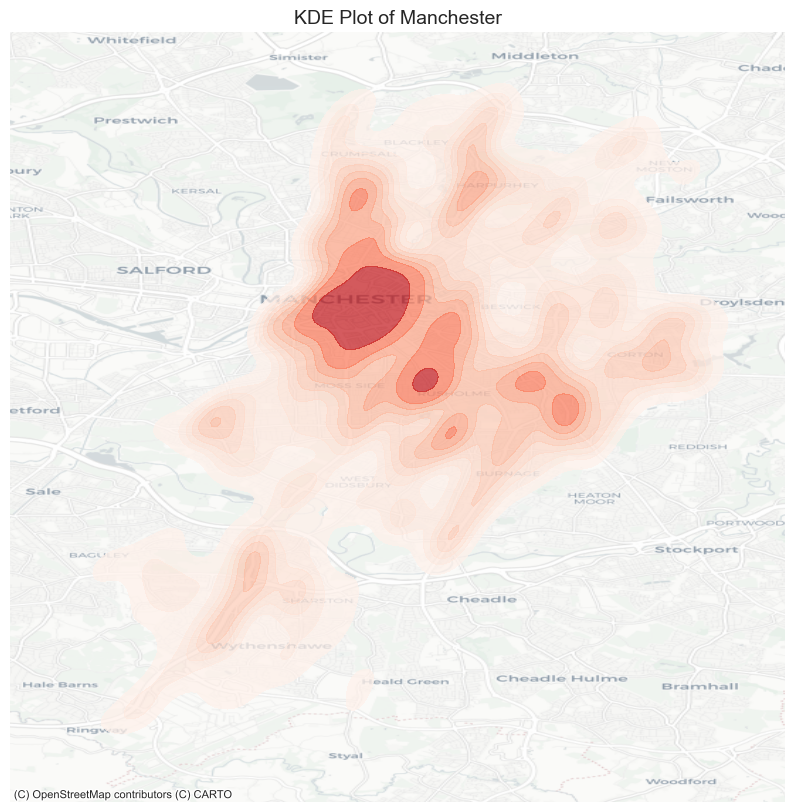

In [134]:
# Manchester
manchester_gdf = geo_accidents[geo_accidents["city"] == "Manchester"]
manchester_gdf = manchester_gdf.to_crs(epsg=3857)
if manchester_gdf.empty:
    print("Empty")
else:
    x_coord = manchester_gdf.geometry.x
    y_coord = manchester_gdf.geometry.y
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.kdeplot(
        x=x_coord, 
        y=y_coord,
        ax=ax,
        cmap="Reds",         
        fill=True,           
        bw_adjust=0.5,       
        thresh=0.05,        
        alpha=0.7,          
        zorder=2             
        )
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title("KDE Plot of Manchester", fontsize=14)
    ax.axis("off")
    plt.show()

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


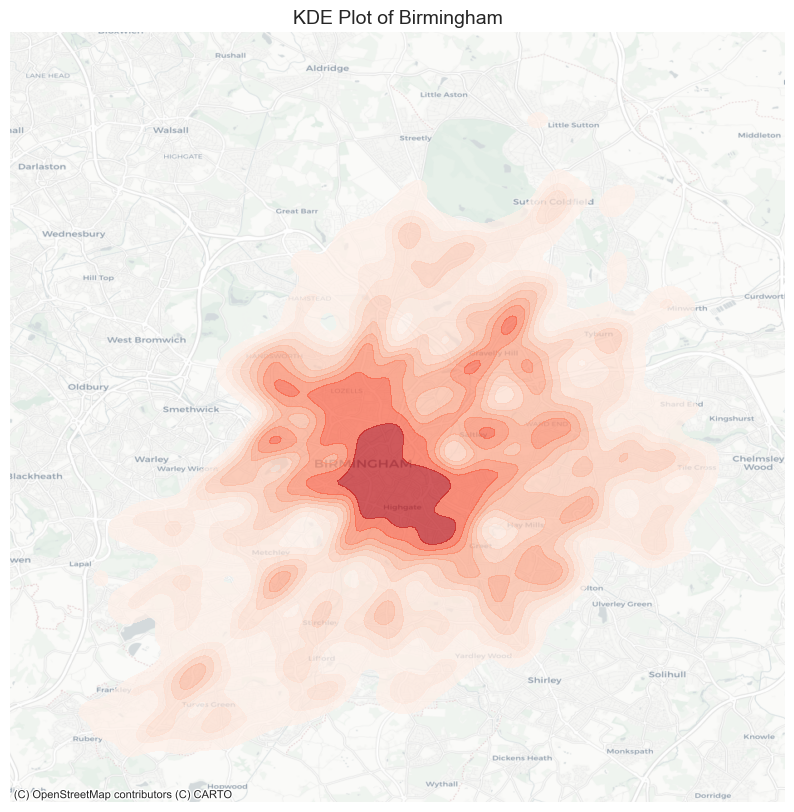

In [135]:
# Birmingham
birmingham_gdf = geo_accidents[geo_accidents["city"] == "Birmingham"]
birmingham_gdf = birmingham_gdf.to_crs(epsg=3857)
if birmingham_gdf.empty:
    print("Empty")
else:
    x_coord = birmingham_gdf.geometry.x
    y_coord = birmingham_gdf.geometry.y
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.kdeplot(
        x=x_coord, 
        y=y_coord,
        ax=ax,
        cmap="Reds",         
        fill=True,           
        bw_adjust=0.5,       
        thresh=0.05,        
        alpha=0.7,          
        zorder=2             
        )
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title("KDE Plot of Birmingham", fontsize=14)
    ax.axis("off")
    plt.show()

In [136]:
### ST-DBSCAN ###

In [137]:
# manchester 

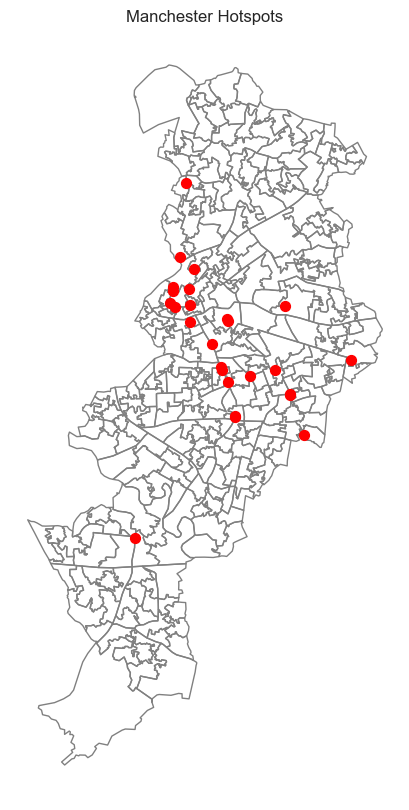

In [138]:
# parameters
eps1 = 200
eps2 = 60
min_samples = 6
# feature matrix
manchester_gdf = geo_accidents[geo_accidents["city"] == "Manchester"].copy()
manchester_gdf = manchester_gdf.dropna(subset=["datetime", "geometry"])
manchester_gdf = manchester_gdf.to_crs(epsg=27700)
spatial_coords = np.array(list(zip(manchester_gdf.geometry.x, manchester_gdf.geometry.y)))
manchester_gdf["time_days"] = (manchester_gdf["datetime"] - manchester_gdf["datetime"].min()).dt.days
X = np.column_stack((spatial_coords, manchester_gdf["time_days"]))
# running st dbscan
st_db = ST_DBSCAN(eps1=eps1, eps2=eps2, min_samples=min_samples)
st_db.fit(X)
manchester_gdf["st_cluster"] = st_db.labels
# filter clusters
clustered = manchester_gdf[manchester_gdf["st_cluster"] != -1]
if clustered.empty:
    print("Empty Cluster")
else:
    centroids = clustered.dissolve(by="st_cluster").centroid
    hotspots = gpd.GeoDataFrame(geometry=centroids, crs=27700)
    hotspots["cluster_id"] = hotspots.index
    hotspots = hotspots.to_crs(epsg=4326)
    hotspots["lat"] = hotspots.geometry.y
    hotspots["lon"] = hotspots.geometry.x
    geo_lsoa = geo_lsoa.to_crs(hotspots.crs)
# reprojection
    geo_lsoa_27700 = geo_lsoa.to_crs(epsg=27700)
# spatial join
    hotspots_names = gpd.sjoin(
        hotspots,
        geo_lsoa[["LSOA21CD", "LSOA21NM", "geometry"]],
        how="left",
        predicate="within"
    ).drop(columns="index_right")
# plot
    hotspots_names = hotspots_names.to_crs(epsg=27700)
    ax = geo_lsoa_27700[geo_lsoa_27700["LSOA21NM"].str.contains("Manchester", case=False)].plot(
        edgecolor="gray", facecolor="none", figsize=(10, 10)
    )
    hotspots_names.plot(ax=ax, color="red", markersize=50)
    plt.title("Manchester Hotspots")
    plt.axis("off")
    plt.show()

In [139]:
#summary
cluster_summary = clustered.groupby("st_cluster").agg(
    n_crashes=("st_cluster", "count"),
    start_date=("datetime", "min"),
    end_date=("datetime", "max"),
    years_present=("datetime", lambda x: sorted(x.dt.year.unique().tolist()))
).reset_index()
cluster_summary

st_cluster  n_crashes          start_date            end_date  \
0            0         11 2019-01-11 11:00:00 2020-03-02 14:00:00   
1            1          8 2019-01-27 17:00:00 2019-11-13 16:00:00   
2            2          7 2019-02-09 20:00:00 2020-01-22 18:00:00   
3            3          8 2019-04-12 22:00:00 2019-12-08 22:00:00   
4            4          7 2019-05-21 17:00:00 2020-02-29 19:00:00   
5            5          6 2019-05-30 18:00:00 2019-12-12 18:00:00   
6            6         16 2019-01-22 06:00:00 2020-04-23 17:00:00   
7            7          8 2019-03-16 02:00:00 2020-02-13 10:00:00   
8            8          6 2019-02-09 19:00:00 2019-11-21 18:00:00   
9            9         11 2019-04-21 15:00:00 2020-06-17 23:00:00   
10          10          9 2019-06-04 18:00:00 2020-09-15 16:00:00   
11          11          6 2019-08-21 14:00:00 2020-03-31 07:00:00   
12          12          7 2020-11-29 19:00:00 2021-08-27 04:00:00   
13          13         15 2021-01-19 08:00:00 2022-09-12 16:00:00   
14          14         10 2021-04-26 17:00:00 2022-08-22 08:00:00   
15          15          6 2021-07-22 17:00:00 2022-03-07 22:00:00   
16          16         10 2021-06-03 00:00:00 2022-11-11 09:00:00   
17          17          6 2021-04-23 17:00:00 2022-04-01 23:00:00   
18          18         28 2021-05-11 15:00:00 2023-07-21 00:00:00   
19          19          6 2021-11-09 16:00:00 2022-09-14 13:00:00   
20          20          5 2021-12-31 22:00:00 2022-09-14 15:00:00   
21          21          8 2022-06-03 15:00:00 2022-09-13 12:00:00   
22          22          6 2022-03-28 15:00:00 2023-03-08 18:00:00   
23          23          6 2022-05-03 16:00:00 2023-01-21 09:00:00   
24          24          6 2022-08-16 18:00:00 2023-03-16 22:00:00   
25          25          6 2023-10-01 02:00:00 2023-12-13 23:00:00   

         years_present  
0         [2019, 2020]  
1               [2019]  
2         [2019, 2020]  
3               [2019]  
4         [2019, 2020]  
5               [2019]  
6         [2019, 2020]  
7         [2019, 2020]  
8               [2019]  
9         [2019, 2020]  
10        [2019, 2020]  
11        [2019, 2020]  
12        [2020, 2021]  
13        [2021, 2022]  
14        [2021, 2022]  
15        [2021, 2022]  
16        [2021, 2022]  
17        [2021, 2022]  
18  [2021, 2022, 2023]  
19        [2021, 2022]  
20        [2021, 2022]  
21              [2022]  
22        [2022, 2023]  
23        [2022, 2023]  
24        [2022, 2023]  
25              [2023]

In [140]:
geolocator = Nominatim(user_agent="crash_hotspot_identifier")

def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), timeout=10)
        if location:
            return location.address
        else:
            return "Unknown"
    except:
        return "Error"

hotspots["address"] = hotspots.apply(lambda row: reverse_geocode(row["lat"], row["lon"]), axis=1)
hotspots["road_name"] = hotspots["address"].str.extract(r'^(.*?),')
sleep(1) 

In [141]:
#summary
hotspots.reset_index(drop=True, inplace=True)  
hotspots["st_cluster"] = hotspots.index   

final_summary = cluster_summary.merge(
    hotspots[["st_cluster", "address", "road_name"]],
    on="st_cluster",
    how="left"
)
final_summary

st_cluster  n_crashes          start_date            end_date  \
0            0         11 2019-01-11 11:00:00 2020-03-02 14:00:00   
1            1          8 2019-01-27 17:00:00 2019-11-13 16:00:00   
2            2          7 2019-02-09 20:00:00 2020-01-22 18:00:00   
3            3          8 2019-04-12 22:00:00 2019-12-08 22:00:00   
4            4          7 2019-05-21 17:00:00 2020-02-29 19:00:00   
5            5          6 2019-05-30 18:00:00 2019-12-12 18:00:00   
6            6         16 2019-01-22 06:00:00 2020-04-23 17:00:00   
7            7          8 2019-03-16 02:00:00 2020-02-13 10:00:00   
8            8          6 2019-02-09 19:00:00 2019-11-21 18:00:00   
9            9         11 2019-04-21 15:00:00 2020-06-17 23:00:00   
10          10          9 2019-06-04 18:00:00 2020-09-15 16:00:00   
11          11          6 2019-08-21 14:00:00 2020-03-31 07:00:00   
12          12          7 2020-11-29 19:00:00 2021-08-27 04:00:00   
13          13         15 2021-01-19 08:00:00 2022-09-12 16:00:00   
14          14         10 2021-04-26 17:00:00 2022-08-22 08:00:00   
15          15          6 2021-07-22 17:00:00 2022-03-07 22:00:00   
16          16         10 2021-06-03 00:00:00 2022-11-11 09:00:00   
17          17          6 2021-04-23 17:00:00 2022-04-01 23:00:00   
18          18         28 2021-05-11 15:00:00 2023-07-21 00:00:00   
19          19          6 2021-11-09 16:00:00 2022-09-14 13:00:00   
20          20          5 2021-12-31 22:00:00 2022-09-14 15:00:00   
21          21          8 2022-06-03 15:00:00 2022-09-13 12:00:00   
22          22          6 2022-03-28 15:00:00 2023-03-08 18:00:00   
23          23          6 2022-05-03 16:00:00 2023-01-21 09:00:00   
24          24          6 2022-08-16 18:00:00 2023-03-16 22:00:00   
25          25          6 2023-10-01 02:00:00 2023-12-13 23:00:00   

         years_present                                            address  \
0         [2019, 2020]  Hyde Road, Brunswick, Ardwick, Manchester, Gre...   
1               [2019]  Trinity Way, Medieval Quarter, Strangeways, Ma...   
2         [2019, 2020]  First Street, City Centre, Manchester, Greater...   
3               [2019]  Beetham Tower, 301-303, Deansgate, St. Johns, ...   
4         [2019, 2020]  Civic Quarter, City Centre, Manchester, Greate...   
5               [2019]  Woodlands Road, Cheetham Hill, Manchester, Gre...   
6         [2019, 2020]  Shell, 10, Wilmslow Road, Curry Mile, Rusholme...   
7         [2019, 2020]  Manchester Metropolitan University – All Saint...   
8               [2019]  581-585, Stockport Road, Longsight, Manchester...   
9         [2019, 2020]  715, Stockport Road, Levenshulme, Manchester, ...   
10        [2019, 2020]  Boland Drive, Fallowfield, Manchester, Greater...   
11        [2019, 2020]  Princess Parkway, Northenden, Manchester, Grea...   
12        [2020, 2021]  Abbeywood Avenue, Reddish Bridge, Gorton, Manc...   
13        [2021, 2022]  Vape & Mobiles, Wilmslow Road, Fallowfield, Ma...   
14        [2021, 2022]  Birchfields Road, Victoria Park, Longsight, Ma...   
15        [2021, 2022]  Ashton Old Road, Beswick, Manchester, Greater ...   
16        [2021, 2022]  MMU Arts Culture & Media Hub, 70, Oxford Stree...   
17        [2021, 2022]  Ardwick Green South, Brunswick, Chorlton-on-Me...   
18  [2021, 2022, 2023]  Jafra, 34-36, Wilmslow Road, Curry Mile, Rusho...   
19        [2021, 2022]  1182, Stockport Road, Levenshulme, Manchester,...   
20        [2021, 2022]  Stone Place, Curry Mile, Rusholme, Manchester,...   
21              [2022]  32, Booth Street, Civic Quarter, City Centre, ...   
22        [2022, 2023]  Stopford Building, Oxford Road, Brunswick, Cho...   
23        [2022, 2023]  725-729, Stockport Road, Levenshulme, Manchest...   
24        [2022, 2023]  Shudehill, Bradshaw Street, Medieval Quarter, ...   
25              [2023]  182, Deansgate, Civic Quarter, City Centre, Ma...   

                                            road_name  
0   

In [142]:
persistent_clusters = final_summary[final_summary['years_present'].apply(lambda x: len(x) >= 2)]
persistent_clusters

st_cluster  n_crashes          start_date            end_date  \
0            0         11 2019-01-11 11:00:00 2020-03-02 14:00:00   
2            2          7 2019-02-09 20:00:00 2020-01-22 18:00:00   
4            4          7 2019-05-21 17:00:00 2020-02-29 19:00:00   
6            6         16 2019-01-22 06:00:00 2020-04-23 17:00:00   
7            7          8 2019-03-16 02:00:00 2020-02-13 10:00:00   
9            9         11 2019-04-21 15:00:00 2020-06-17 23:00:00   
10          10          9 2019-06-04 18:00:00 2020-09-15 16:00:00   
11          11          6 2019-08-21 14:00:00 2020-03-31 07:00:00   
12          12          7 2020-11-29 19:00:00 2021-08-27 04:00:00   
13          13         15 2021-01-19 08:00:00 2022-09-12 16:00:00   
14          14         10 2021-04-26 17:00:00 2022-08-22 08:00:00   
15          15          6 2021-07-22 17:00:00 2022-03-07 22:00:00   
16          16         10 2021-06-03 00:00:00 2022-11-11 09:00:00   
17          17          6 2021-04-23 17:00:00 2022-04-01 23:00:00   
18          18         28 2021-05-11 15:00:00 2023-07-21 00:00:00   
19          19          6 2021-11-09 16:00:00 2022-09-14 13:00:00   
20          20          5 2021-12-31 22:00:00 2022-09-14 15:00:00   
22          22          6 2022-03-28 15:00:00 2023-03-08 18:00:00   
23          23          6 2022-05-03 16:00:00 2023-01-21 09:00:00   
24          24          6 2022-08-16 18:00:00 2023-03-16 22:00:00   

         years_present                                            address  \
0         [2019, 2020]  Hyde Road, Brunswick, Ardwick, Manchester, Gre...   
2         [2019, 2020]  First Street, City Centre, Manchester, Greater...   
4         [2019, 2020]  Civic Quarter, City Centre, Manchester, Greate...   
6         [2019, 2020]  Shell, 10, Wilmslow Road, Curry Mile, Rusholme...   
7         [2019, 2020]  Manchester Metropolitan University – All Saint...   
9         [2019, 2020]  715, Stockport Road, Levenshulme, Manchester, ...   
10        [2019, 2020]  Boland Drive, Fallowfield, Manchester, Greater...   
11        [2019, 2020]  Princess Parkway, Northenden, Manchester, Grea...   
12        [2020, 2021]  Abbeywood Avenue, Reddish Bridge, Gorton, Manc...   
13        [2021, 2022]  Vape & Mobiles, Wilmslow Road, Fallowfield, Ma...   
14        [2021, 2022]  Birchfields Road, Victoria Park, Longsight, Ma...   
15        [2021, 2022]  Ashton Old Road, Beswick, Manchester, Greater ...   
16        [2021, 2022]  MMU Arts Culture & Media Hub, 70, Oxford Stree...   
17        [2021, 2022]  Ardwick Green South, Brunswick, Chorlton-on-Me...   
18  [2021, 2022, 2023]  Jafra, 34-36, Wilmslow Road, Curry Mile, Rusho...   
19        [2021, 2022]  1182, Stockport Road, Levenshulme, Manchester,...   
20        [2021, 2022]  Stone Place, Curry Mile, Rusholme, Manchester,...   
22        [2022, 2023]  Stopford Building, Oxford Road, Brunswick, Cho...   
23        [2022, 2023]  725-729, Stockport Road, Levenshulme, Manchest...   
24        [2022, 2023]  Shudehill, Bradshaw Street, Medieval Quarter, ...   

                                            road_name  
0                                           Hyde Road  
2                                        First Street  
4                                       Civic Quarter  
6                                               Shell  
7   Manchester Metropolitan University – All Saint...  
9                                                 715  
10                                       Boland Drive  
11                                   Princess Parkway  
12                                   Abbeywood Avenue  
13                                     Vape & Mobiles  
14                                   Birchfields Road  
15                                    Ashton Old Road  
16                       MMU Arts Culture & Media Hub  
17                                Ardwick Green South  
18                                              Jafra  
19                                      

In [144]:
# birmingham

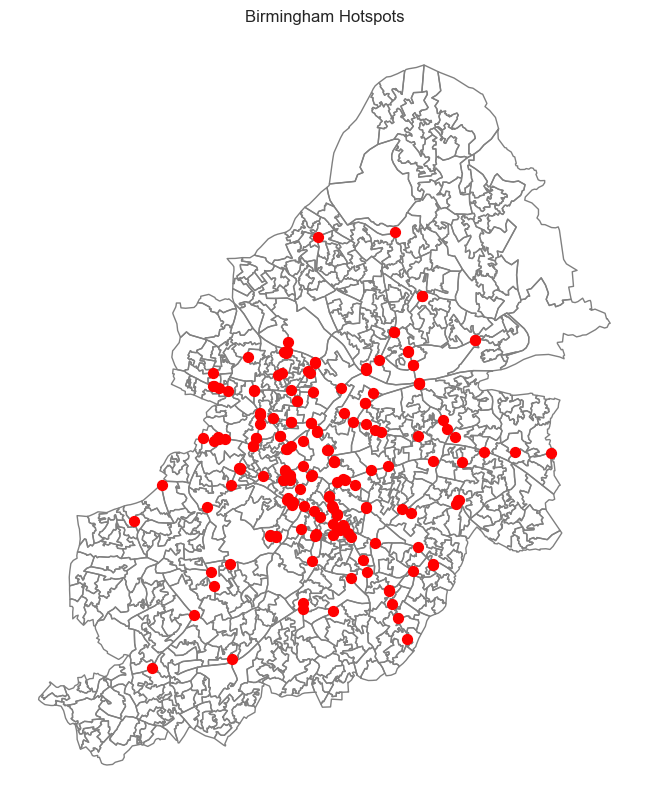

In [145]:
eps1 = 200
eps2 = 60
min_samples = 6
# feature matrix
birmingham_gdf = geo_accidents[geo_accidents["city"] == "Birmingham"].copy()
birmingham_gdf = birmingham_gdf.dropna(subset=["datetime", "geometry"])
birmingham_gdf = birmingham_gdf.to_crs(epsg=27700)
spatial_coords = np.array(list(zip(birmingham_gdf.geometry.x, birmingham_gdf.geometry.y)))
birmingham_gdf["time_days"] = (birmingham_gdf["datetime"] - birmingham_gdf["datetime"].min()).dt.days
X = np.column_stack((spatial_coords, birmingham_gdf["time_days"]))
# running st dbscan
st_db = ST_DBSCAN(eps1=eps1, eps2=eps2, min_samples=min_samples)
st_db.fit(X)
birmingham_gdf["st_cluster"] = st_db.labels
# filter clusters
clustered = birmingham_gdf[birmingham_gdf["st_cluster"] != -1]
if clustered.empty:
    print("Empty Cluster")
else:
    centroids = clustered.dissolve(by="st_cluster").centroid
    hotspots = gpd.GeoDataFrame(geometry=centroids, crs=27700)
    hotspots["cluster_id"] = hotspots.index
    hotspots = hotspots.to_crs(epsg=4326)
    hotspots["lat"] = hotspots.geometry.y
    hotspots["lon"] = hotspots.geometry.x
    geo_lsoa = geo_lsoa.to_crs(hotspots.crs)
# reprojection
    geo_lsoa_27700 = geo_lsoa.to_crs(epsg=27700)
# spatial join
    hotspots_names = gpd.sjoin(
        hotspots,
        geo_lsoa[["LSOA21CD", "LSOA21NM", "geometry"]],
        how="left",
        predicate="within"
    ).drop(columns="index_right")
# plot
    hotspots_names = hotspots_names.to_crs(epsg=27700)
    ax = geo_lsoa_27700[geo_lsoa_27700["LSOA21NM"].str.contains("Birmingham", case=False)].plot(
        edgecolor="gray", facecolor="none", figsize=(10, 10)
    )
    hotspots_names.plot(ax=ax, color="red", markersize=50)
    plt.title("Birmingham Hotspots")
    plt.axis("off")
    plt.show()

In [146]:
#summary
cluster_summary = clustered.groupby("st_cluster").agg(
    n_crashes=("st_cluster", "count"),
    start_date=("datetime", "min"),
    end_date=("datetime", "max"),
    years_present=("datetime", lambda x: sorted(x.dt.year.unique().tolist()))
).reset_index()
cluster_summary

st_cluster  n_crashes          start_date            end_date  \
0             0         20 2019-01-12 07:00:00 2020-03-05 18:00:00   
1             1         18 2019-01-08 05:00:00 2020-10-15 12:00:00   
2             2          6 2019-01-27 04:00:00 2019-05-12 16:00:00   
3             3         23 2019-02-03 23:00:00 2020-07-08 08:00:00   
4             4         78 2019-02-02 12:00:00 2023-12-04 15:00:00   
..          ...        ...                 ...                 ...   
170         170          6 2023-01-13 18:00:00 2023-12-28 18:00:00   
171         171          6 2023-04-25 10:00:00 2023-12-30 17:00:00   
172         172          6 2023-07-04 13:00:00 2023-11-30 08:00:00   
173         173          6 2023-07-19 15:00:00 2023-12-28 17:00:00   
174         174          6 2023-04-29 21:00:00 2023-11-03 21:00:00   

                      years_present  
0                      [2019, 2020]  
1                      [2019, 2020]  
2                            [2019]  
3                      [2019, 2020]  
4    [2019, 2020, 2021, 2022, 2023]  
..                              ...  
170                          [2023]  
171                          [2023]  
172                          [2023]  
173                          [2023]  
174                          [2023]  

[175 rows x 5 columns]

In [147]:
geolocator = Nominatim(user_agent="crash_hotspot_identifier")

def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), timeout=10)
        if location:
            return location.address
        else:
            return "Unknown"
    except:
        return "Error"

hotspots["address"] = hotspots.apply(lambda row: reverse_geocode(row["lat"], row["lon"]), axis=1)
hotspots["road_name"] = hotspots["address"].str.extract(r'^(.*?),')
sleep(1) 

In [148]:
#summary
hotspots.reset_index(drop=True, inplace=True)  
hotspots["st_cluster"] = hotspots.index   

final_summary = cluster_summary.merge(
    hotspots[["st_cluster", "address", "road_name"]],
    on="st_cluster",
    how="left"
)
final_summary

st_cluster  n_crashes          start_date            end_date  \
0             0         20 2019-01-12 07:00:00 2020-03-05 18:00:00   
1             1         18 2019-01-08 05:00:00 2020-10-15 12:00:00   
2             2          6 2019-01-27 04:00:00 2019-05-12 16:00:00   
3             3         23 2019-02-03 23:00:00 2020-07-08 08:00:00   
4             4         78 2019-02-02 12:00:00 2023-12-04 15:00:00   
..          ...        ...                 ...                 ...   
170         170          6 2023-01-13 18:00:00 2023-12-28 18:00:00   
171         171          6 2023-04-25 10:00:00 2023-12-30 17:00:00   
172         172          6 2023-07-04 13:00:00 2023-11-30 08:00:00   
173         173          6 2023-07-19 15:00:00 2023-12-28 17:00:00   
174         174          6 2023-04-29 21:00:00 2023-11-03 21:00:00   

                      years_present  \
0                      [2019, 2020]   
1                      [2019, 2020]   
2                            [2019]   
3                      [2019, 2020]   
4    [2019, 2020, 2021, 2022, 2023]   
..                              ...   
170                          [2023]   
171                          [2023]   
172                          [2023]   
173                          [2023]   
174                          [2023]   

                                               address  \
0    Pershore Road, Attwood Green, Digbeth, Park Ce...   
1    Salford Circus, Nechells, Birmingham, West Mid...   
2    Hampton by Hilton Birmingham Broad Street, 200...   
3    Ladbrokes, 343-345, Stratford Road, Sparkhill,...   
4    Bordesley Circus, Digbeth, Sparkbrook, Birming...   
..                                                 ...   
170  Washwood Heath Road, Ward End, Birmingham, Wes...   
171  Arthur Street, Digbeth, Sparkbrook, Birmingham...   
172  Edmunson Electrical, 1, Mainstream Way, Vauxha...   
173  306, Station Road, Stechford, Birmingham, West...   
174  Queensway, Jewellery Quarter, Birmingham, West...   

                                     road_name  
0                                Pershore Road  
1                               Salford Circus  
2    Hampton by Hilton Birmingham Broad Street  
3                                    Ladbrokes  
4                             Bordesley Circus  
..                                         ...  
170                        Washwood Heath Road  
171                              Arthur Street  
172                        Edmunson Electrical  
173                                        306  
174                                  Queensway  

[175 rows x 7 columns]

In [149]:
persistent_clusters = final_summary[final_summary['years_present'].apply(lambda x: len(x) >= 3)]
persistent_clusters

st_cluster  n_crashes          start_date            end_date  \
4             4         78 2019-02-02 12:00:00 2023-12-04 15:00:00   
8             8         40 2019-01-07 18:00:00 2021-01-26 17:00:00   
13           13         19 2019-01-07 08:00:00 2021-07-10 13:00:00   
22           22         20 2019-03-22 20:00:00 2021-04-14 16:00:00   
48           48         11 2019-10-14 15:00:00 2021-02-06 17:00:00   
51           51         42 2019-06-05 23:00:00 2023-05-24 13:00:00   
55           55          7 2019-09-20 15:00:00 2021-02-02 17:00:00   
61           61         41 2020-05-24 13:00:00 2023-11-03 23:00:00   
63           63         42 2020-10-24 20:00:00 2023-11-09 12:00:00   
65           65         21 2020-07-04 07:00:00 2023-05-15 17:00:00   
70           70         21 2020-10-30 22:00:00 2023-11-15 19:00:00   
72           72         11 2020-10-12 19:00:00 2022-01-22 15:00:00   
73           73         12 2020-11-28 17:00:00 2022-06-23 17:00:00   
78           78          6 2020-12-27 17:00:00 2022-01-04 07:00:00   
80           80          8 2020-12-18 18:00:00 2022-05-09 19:00:00   
82           82         20 2021-04-12 18:00:00 2023-05-23 19:00:00   
87           87         23 2021-01-15 16:00:00 2023-05-28 15:00:00   
96           96         14 2021-07-25 19:00:00 2023-05-12 16:00:00   
99           99         16 2021-08-09 04:00:00 2023-01-07 16:00:00   
101         101         14 2021-08-06 16:00:00 2023-07-22 03:00:00   
102         102         16 2021-03-05 23:00:00 2023-02-03 18:00:00   
113         113         13 2021-10-09 18:00:00 2023-04-24 08:00:00   
126         126         12 2021-11-10 06:00:00 2023-07-15 18:00:00   
131         131         18 2021-12-15 07:00:00 2023-10-10 16:00:00   

                      years_present  \
4    [2019, 2020, 2021, 2022, 2023]   
8                [2019, 2020, 2021]   
13               [2019, 2020, 2021]   
22               [2019, 2020, 2021]   
48               [2019, 2020, 2021]   
51   [2019, 2020, 2021, 2022, 2023]   
55               [2019, 2020, 2021]   
61         [2020, 2021, 2022, 2023]   
63         [2020, 2021, 2022, 2023]   
65         [2020, 2021, 2022, 2023]   
70         [2020, 2021, 2022, 2023]   
72               [2020, 2021, 2022]   
73               [2020, 2021, 2022]   
78               [2020, 2021, 2022]   
80               [2020, 2021, 2022]   
82               [2021, 2022, 2023]   
87               [2021, 2022, 2023]   
96               [2021, 2022, 2023]   
99               [2021, 2022, 2023]   
101              [2021, 2022, 2023]   
102              [2021, 2022, 2023]   
113              [2021, 2022, 2023]   
126              [2021, 2022, 2023]   
131              [2021, 2022, 2023]   

                                               address  \
4    Bordesley Circus, Digbeth, Sparkbrook, Birming...   
8    O2 Academy, Horsefair, Chinese Quarter, Digbet...   
13   Garrison Circus, Bordesley, Saltley, Birmingha...   
22   Golden Hillock Road, Sparkhill, Greet, Birming...   
48   Selly Oak, Metchley, Birmingham, West Midlands...   
51   Haden Circus, Digbeth, Highgate, Birmingham, W...   
55   Chester Road, Wylde Green, Erdington, Birmingh...   
61   Bristol Street, Attwood Green, Digbeth, Park C...   
63   Stoney Lane, Sparkhill, Sparkbrook, Birmingham...   
65   Stratford Road, Hall Green, Birmingham, West M...   
70   Nechells, Birmingham, West Midlands, England, ...   
72   Newbury Road, Newtown, Lozells, Birmingham, We...   
73   66, Holloway Head, Attwood Green, Edgbaston, P...   
78   Sir Herbert Austin Way, Northfield, Turves Gre...   
80   Hockley Circus, Jewellery Quarter, Birmingham,...   
82   545, Moseley Road, Moseley, Balsall Heath, Bir...   
87   Lancaster Circus Queensway, Digbeth, Birmingha...   
96   Warwick Road, Acocks Green, Tyseley, Birmingha...   
99   Lucas Circus, Jewellery Quarter, Birmingham, W...   
101  Macdonald Street, Rea Valley, Digbeth, Highgat...   
102  Six Ways, Erdington, Gravelly Hill, Birmingham...   
11

In [150]:
### TEMPORAL ANALYSIS ###

In [151]:
accidents_data["year"] = accidents_data["datetime"].dt.year
accidents_data["month"] = accidents_data["datetime"].dt.month
accidents_data["month_name"] = accidents_data["datetime"].dt.strftime("%B")
accidents_data["weekday"] = accidents_data["datetime"].dt.day_name()
accidents_data["hour"] = accidents_data["datetime"].dt.hour
accidents_data["year_month"] = accidents_data["datetime"].dt.to_period("M").astype(str)

In [ ]:
# HOURLY CHARTS #

In [152]:
# grouping accidents by city and hour
hourly_max = (
    accidents_data.groupby(["city", "hour"])
    .size()
    .groupby("city")
    .max()
    .max()  # get the overall maximum across both cities
)

In [ ]:
# manchester
sns.countplot(
    data=accidents_data[accidents_data["city"] == "Manchester"],
    x="hour",
    palette="coolwarm"
)
plt.ylim(0, hourly_max + 10) 
plt.title("Hourly Accident Pattern – Manchester", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

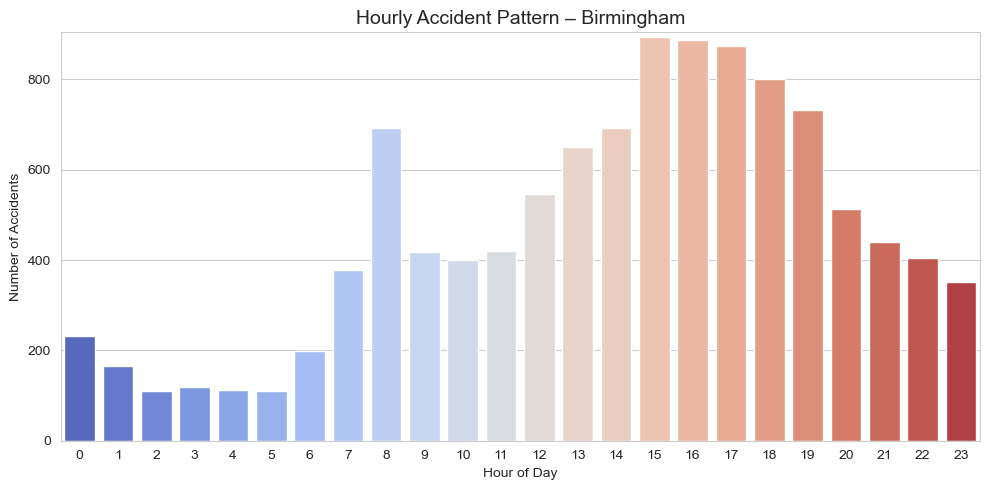

In [153]:
# birmingham
plt.figure(figsize=(10, 5))
sns.countplot(
    data=accidents_data[accidents_data["city"] == "Birmingham"],
    x="hour",
    palette="coolwarm"
)
plt.ylim(0, hourly_max + 10)  # same y-axis scale
plt.title("Hourly Accident Pattern – Birmingham", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

In [154]:
# WEEKLY CHARTS #

In [155]:
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
accidents_data['weekday_name'] = accidents_data['day_of_week'].map(dict(enumerate(day_labels)))
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

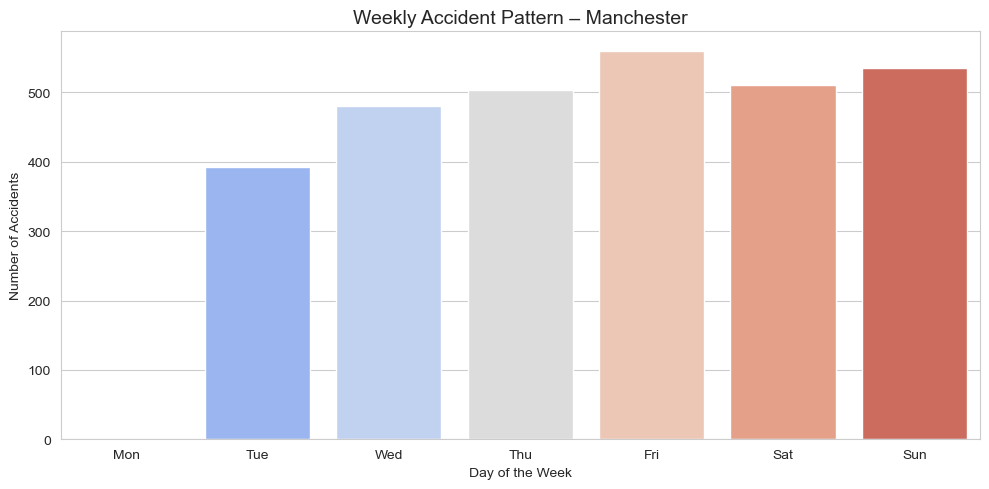

In [156]:
# manchester
manchester_data = accidents_data[accidents_data['city'] == 'Manchester']
plt.figure(figsize=(10, 5))
sns.countplot(
    data=manchester_data,
    x='weekday_name',
    order=weekday_order,
    palette='coolwarm'
)
plt.title("Weekly Accident Pattern – Manchester", fontsize=14)
plt.xlabel("Day of the Week")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

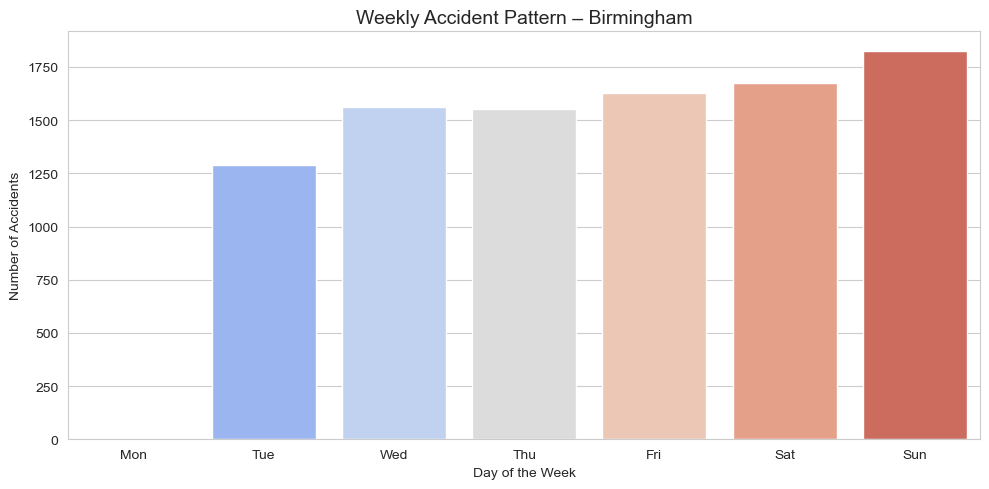

In [157]:
# birmingham
birmingham_data = accidents_data[accidents_data['city'] == 'Birmingham']
plt.figure(figsize=(10, 5))
sns.countplot(
    data=birmingham_data,
    x='weekday_name',
    order=weekday_order,
    palette='coolwarm'
)
plt.title("Weekly Accident Pattern – Birmingham", fontsize=14)
plt.xlabel("Day of the Week")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

In [158]:
# YEARLY CHARTS #

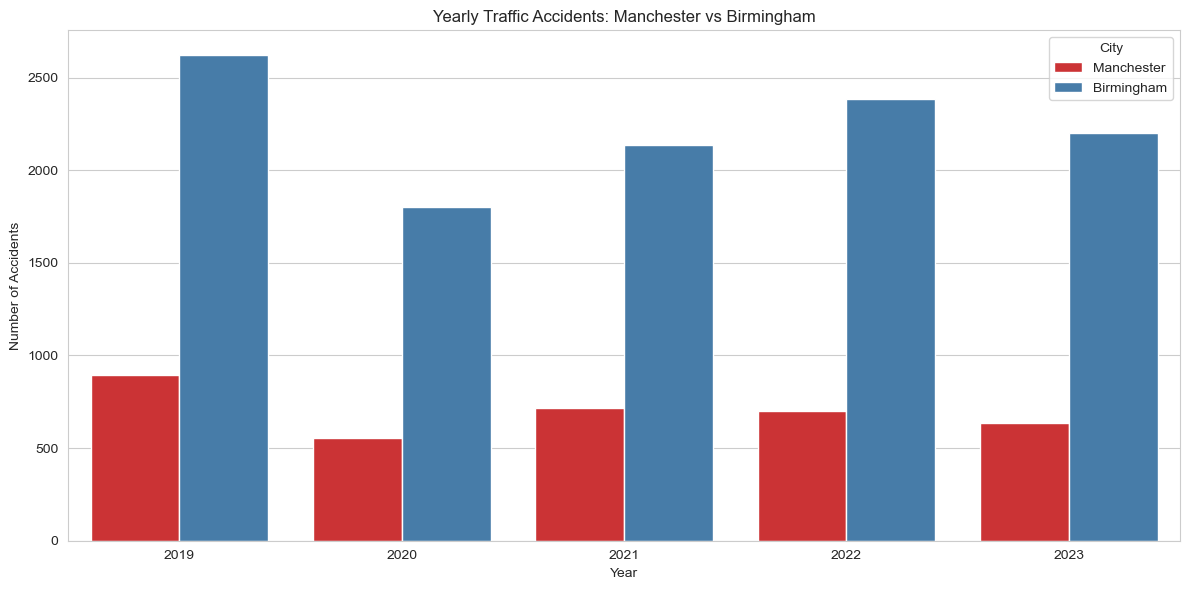

In [159]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=accidents_data,
    x="year",
    hue="city",
    palette="Set1"
)
plt.title("Yearly Traffic Accidents: Manchester vs Birmingham")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.legend(title="City")
plt.tight_layout()
plt.show()

In [165]:
# MONTHLY" CHARTS #

In [166]:
monthly_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

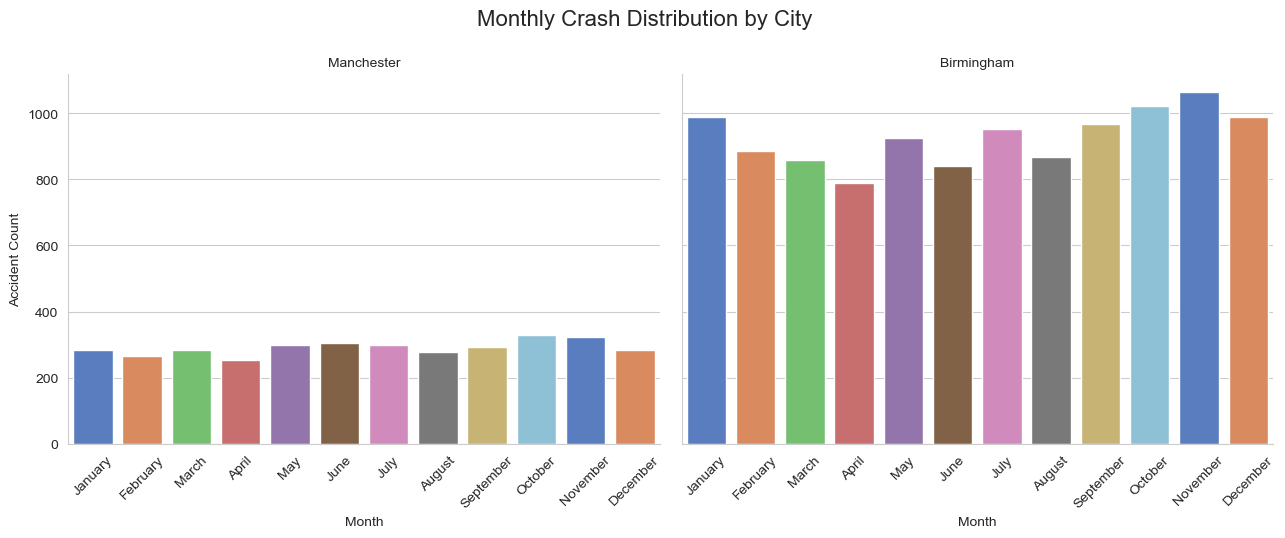

In [167]:
g = sns.catplot(
    data=accidents_data,
    x="month_name",
    order=monthly_order,
    kind="count",
    col="city",
    col_order=["Manchester", "Birmingham"],
    sharey=True,
    palette="muted",
    height=5,
    aspect=1.3
)

g.set_titles("{col_name}")
g.set_axis_labels("Month", "Accident Count")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Monthly Crash Distribution by City", fontsize=16)
plt.show()

In [172]:
# summary stats table

In [173]:
# total crashes
crash_counts = accidents_data.groupby("city").size().reset_index(name="total_crashes")
print(crash_counts)

         city  total_crashes
0  Birmingham          11144
1  Manchester           3498


In [176]:
lsoa_with_accidents["city"] = lsoa_with_accidents["LSOA21NM"].apply(
    lambda x: "Manchester" if "Manchester" in x else ("Birmingham" if "Birmingham" in x else None)
)
print(lsoa_with_accidents["city"].value_counts())

city
Birmingham    659
Manchester    295
Name: count, dtype: int64


In [177]:
city_lookup = lsoa_with_accidents[["LSOA21CD", "city"]].drop_duplicates()
final_data = final_data.merge(city_lookup, on="LSOA21CD", how="left")

In [178]:
final_data["city"].isna().sum()

0

In [179]:
# crashes per km
final_data["road_km"] = final_data["road_length"] / 1000
final_data["crashes_per_km"] = final_data["accident_count"] / final_data["road_km"]
crash_km_by_city = final_data.groupby("city").agg({
    "accident_count": "sum",
    "road_km": "sum"
}).reset_index()
crash_km_by_city["crashes_per_km"] = crash_km_by_city["accident_count"] / crash_km_by_city["road_km"]
print(crash_km_by_city)

         city  accident_count      road_km  crashes_per_km
0  Birmingham           11110  5002.457437        2.220908
1  Manchester            3496  2662.029801        1.313284


In [180]:
##### OBJECTIVE 2 #####

In [181]:
### MULTIVARIATE REGRESSION ###

In [182]:
features = [
    "road_length",
    "avg_daily_traffic_idw",
    "temperature_2m",
    "precipitation",
    "snowfall",
    "wind_speed_10m",
    "cloud_cover_low",
    "relative_humidity_2m"
]
mr = final_data[features + ["accident_count"]].dropna()
X = mr[features]
y = mr["accident_count"]
X = sm.add_constant(X)
mr_model = sm.OLS(y, X).fit()
print(mr_model.summary())

                            OLS Regression Results                            
Dep. Variable:         accident_count   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     34.88
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           2.05e-48
Time:                        22:38:14   Log-Likelihood:                -3832.4
No. Observations:                 944   AIC:                             7683.
Df Residuals:                     935   BIC:                             7727.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -43.92

In [184]:
# VIF
mr_model = final_data[features + ["accident_count"]].dropna()
X = mr_model[features]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                Variable         VIF
0                  const  483.724202
1            road_length    1.051335
2  avg_daily_traffic_idw    1.054746
3         temperature_2m    1.619719
4          precipitation    1.159207
5               snowfall    1.062266
6         wind_speed_10m    1.056337
7        cloud_cover_low    1.130093
8   relative_humidity_2m    1.804887


In [185]:
### GWR ###

In [186]:
# manchester

In [220]:
man_data = final_data[final_data["city"] == "Manchester"]
bir_data = final_data[final_data["city"] == "Birmingham"]
gdf = final_data.to_crs(epsg=27700).copy()

In [222]:
man_gdf = man_data.to_crs(epsg=27700).copy()
man_gdf["x"] = man_gdf.geometry.centroid.x
man_gdf["y"] = man_gdf.geometry.centroid.y

predictors = [
    "road_length", "avg_daily_traffic_idw", "temperature_2m",
    "precipitation", "snowfall", "wind_speed_10m",
    "cloud_cover_low", "relative_humidity_2m"
]

gwr = man_gdf[["accident_count", "x", "y"] + predictors].dropna()

coords = gwr[["x", "y"]].values
y = gwr["accident_count"].values.reshape((-1, 1))
X = gwr[predictors].values

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
bw = Sel_BW(coords, y, X_std).search(bw_min=2)
print(f"Optimal bandwidth: {bw}")
gwr_model = GWR(coords, y, X_std, bw)
gwr_results = gwr_model.fit()
print(gwr_results.summary())

params = pd.DataFrame(
    gwr_results.params,
    columns=["Intercept"] + predictors
)

gdf_gwr = gwr.copy()
gdf_gwr = gpd.GeoDataFrame(gdf_gwr, geometry=gdf.loc[gwr.index, "geometry"])
for i, col in enumerate(["Intercept"] + predictors):
    gdf_gwr[f"gwr_{col}"] = gwr_results.params[:, i]

Optimal bandwidth: 133.0
Model type                                                         Gaussian
Number of observations:                                                 292
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          23989.704
Log-likelihood:                                                   -1057.989
AIC:                                                               2133.979
AICc:                                                              2136.762
BIC:                                                              22383.183
R2:                                                                   0.316
Adj. R2:                                                              0.297

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---

In [224]:
# birmingham

In [228]:
bir_gdf = bir_data.to_crs(epsg=27700).copy()
bir_gdf["x"] = bir_gdf.geometry.centroid.x
bir_gdf["y"] = bir_gdf.geometry.centroid.y

predictors = [
    "road_length", "avg_daily_traffic_idw", "temperature_2m",
    "precipitation", "snowfall", "wind_speed_10m",
    "cloud_cover_low", "relative_humidity_2m"
]

gwr = bir_gdf[["accident_count", "x", "y"] + predictors].dropna()

coords = gwr[["x", "y"]].values
y = gwr["accident_count"].values.reshape((-1, 1))
X = gwr[predictors].values

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
bw = Sel_BW(coords, y, X_std).search(bw_min=2)
print(f"Optimal bandwidth: {bw}")
gwr_model = GWR(coords, y, X_std, bw)
gwr_results = gwr_model.fit()
print(gwr_results.summary())

params = pd.DataFrame(
    gwr_results.params,
    columns=["Intercept"] + predictors
)

gdf_gwr = gwr.copy()
gdf_gwr = gpd.GeoDataFrame(gdf_gwr, geometry=gdf.loc[gwr.index, "geometry"])
for i, col in enumerate(["Intercept"] + predictors):
    gdf_gwr[f"gwr_{col}"] = gwr_results.params[:, i]

Optimal bandwidth: 192.0
Model type                                                         Gaussian
Number of observations:                                                 652
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         134545.181
Log-likelihood:                                                   -2662.601
AIC:                                                               5343.202
AICc:                                                              5345.545
BIC:                                                             130378.512
R2:                                                                   0.330
Adj. R2:                                                              0.322

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---

In [230]:
### RANDOM FOREST ###

In [232]:
final_data.columns.tolist()

['LSOA21CD',
 'LSOA21NM',
 'LSOA21NMW',
 'BNG_E',
 'BNG_N',
 'LAT',
 'LONG',
 'GlobalID',
 'geometry',
 'accident_count',
 'avg_severity',
 'road_length',
 'avg_daily_traffic',
 'has_traffic',
 'centroid',
 'avg_daily_traffic_idw',
 'temperature_2m',
 'precipitation',
 'snowfall',
 'wind_speed_10m',
 'cloud_cover_low',
 'relative_humidity_2m',
 'city',
 'road_km',
 'crashes_per_km']

In [ ]:
# manchester

In [234]:
features = [
    "road_length", "avg_daily_traffic_idw", 
    "temperature_2m", "precipitation", "snowfall", "wind_speed_10m",
    "cloud_cover_low", "relative_humidity_2m"
]
df_ml = man_data[features + ["accident_count"]].dropna()
X = df_ml[features]
X["road_length_log"] = np.log1p(X["road_length"])
X["avg_daily_traffic_idw_log"] = np.log1p(X["avg_daily_traffic_idw"])
y = df_ml["accident_count"]
y_log = np.log1p(y)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
man_rf = RandomForestRegressor(n_estimators=500, random_state=42)
man_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [236]:
# manchester model fit performance
y_pred = man_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.442
MAE: 5.45
RMSE: 7.91


In [242]:
# hyperparameter tuning
features = [
    "road_length", "avg_daily_traffic_idw", 
    "temperature_2m", "precipitation", "snowfall", "wind_speed_10m",
    "cloud_cover_low", "relative_humidity_2m"
]

df_ml = man_data[features + ["accident_count"]].dropna().copy()

df_ml["road_length_log"] = np.log1p(df_ml["road_length"])
df_ml["avg_daily_traffic_idw_log"] = np.log1p(df_ml["avg_daily_traffic_idw"])
df_ml["temperature_2m_log"] = np.log1p(df_ml["temperature_2m"])
df_ml["precipitation_log"] = np.log1p(df_ml["precipitation"])
df_ml["snowfall_log"] = np.log1p(df_ml["snowfall"])
df_ml["wind_speed_10m_log"] = np.log1p(df_ml["wind_speed_10m"])
df_ml["cloud_cover_low_log"] = np.log1p(df_ml["cloud_cover_low"])
df_ml["relative_humidity_2m_log"] = np.log1p(df_ml["relative_humidity_2m"])

X = df_ml[features]
y = df_ml["accident_count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [243]:
# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Best Parameters:", random_search.best_params_)
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 290}
R²: 0.4822
MAE: 5.21
RMSE: 7.62


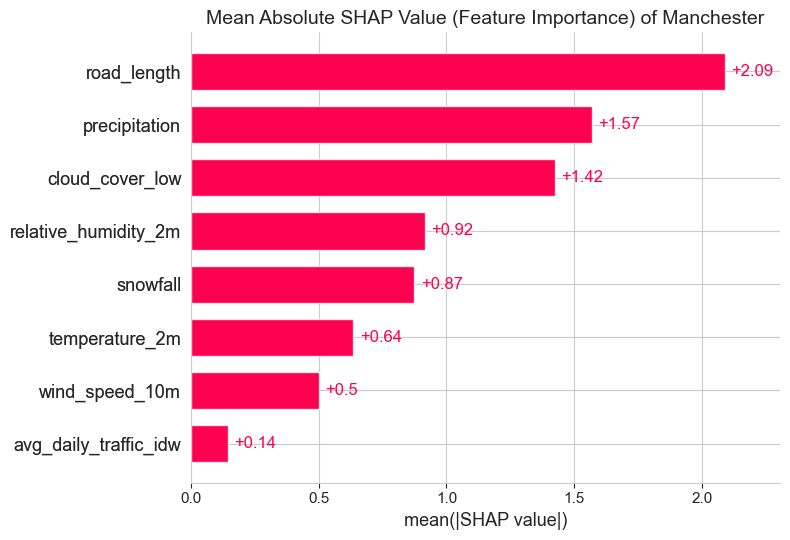

In [244]:
# shap
explainer = shap.Explainer(best_rf, X_test)
shap_values = explainer(X_test)

plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values, show=False)
plt.title("Mean Absolute SHAP Value (Feature Importance) of Manchester", fontsize=14)
plt.tight_layout()
plt.show()

In [248]:
# birmingham

In [250]:
features = [
    "road_length", "avg_daily_traffic_idw", 
    "temperature_2m", "precipitation", "snowfall", "wind_speed_10m",
    "cloud_cover_low", "relative_humidity_2m"
]
df_ml = bir_data[features + ["accident_count"]].dropna()
X = df_ml[features]
X["road_length_log"] = np.log1p(X["road_length"])
X["avg_daily_traffic_idw_log"] = np.log1p(X["avg_daily_traffic_idw"])
y = df_ml["accident_count"]
y_log = np.log1p(y)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
bir_rf = RandomForestRegressor(n_estimators=500, random_state=42)
bir_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [251]:
# birmingham model fit performance
y_pred = bir_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.550
MAE: 8.19
RMSE: 13.19


In [254]:
# hyperparameter tuning
features = [
    "road_length", "avg_daily_traffic_idw", 
    "temperature_2m", "precipitation", "snowfall", "wind_speed_10m",
    "cloud_cover_low", "relative_humidity_2m"
]

df_ml = bir_data[features + ["accident_count"]].dropna().copy()

df_ml["road_length_log"] = np.log1p(df_ml["road_length"])
df_ml["avg_daily_traffic_idw_log"] = np.log1p(df_ml["avg_daily_traffic_idw"])
df_ml["temperature_2m_log"] = np.log1p(df_ml["temperature_2m"])
df_ml["precipitation_log"] = np.log1p(df_ml["precipitation"])
df_ml["snowfall_log"] = np.log1p(df_ml["snowfall"])
df_ml["wind_speed_10m_log"] = np.log1p(df_ml["wind_speed_10m"])
df_ml["cloud_cover_low_log"] = np.log1p(df_ml["cloud_cover_low"])
df_ml["relative_humidity_2m_log"] = np.log1p(df_ml["relative_humidity_2m"])

X = df_ml[features]
y = df_ml["accident_count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [255]:
# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Best Parameters:", random_search.best_params_)
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 149}
R²: 0.5170
MAE: 8.34
RMSE: 13.67


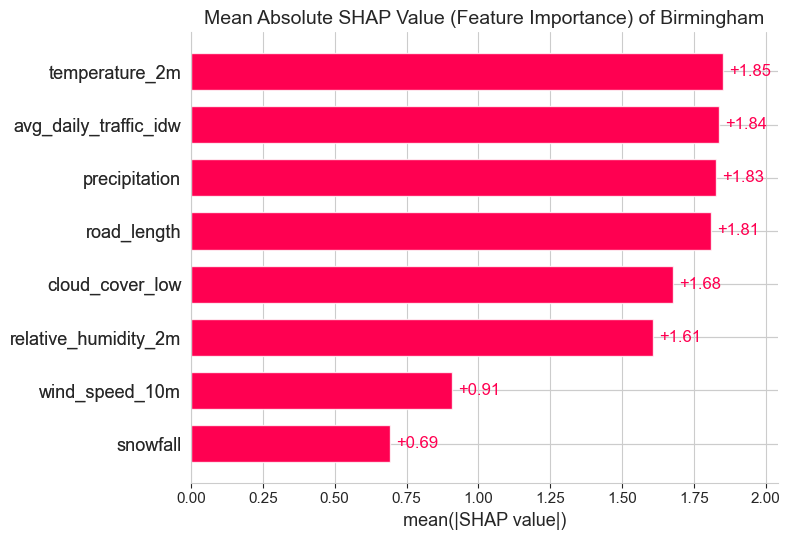

In [256]:
# shap
explainer = shap.Explainer(best_rf, X_test)
shap_values = explainer(X_test)

plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values, show=False)
plt.title("Mean Absolute SHAP Value (Feature Importance) of Birmingham", fontsize=14)
plt.tight_layout()
plt.show()

In [260]:
##### OBJECTIVE 3 #####

In [262]:
manchester_data = final_data[final_data["city"] == "Manchester"]
birmingham_data = final_data[final_data["city"] == "Birmingham"]

In [264]:
# crashes per km
man_mean = manchester_data["crashes_per_km"].mean()
man_median = manchester_data["crashes_per_km"].median()
man_std = manchester_data["crashes_per_km"].std()
bir_mean = birmingham_data["crashes_per_km"].mean()
bir_median = birmingham_data["crashes_per_km"].median()
bir_std = birmingham_data["crashes_per_km"].std()
print(round(man_mean, 4))
print(round(man_median,4))
print(round(man_std,4))
print(round(bir_mean, 4))
print(round(bir_median, 4))
print(round(bir_std, 4))

1.3566
1.0607
1.143
2.2779
1.6993
1.8679


In [266]:
# crashes per 10000 vehicles
final_data["crashes_per_10000_vehicles"] = final_data["accident_count"] / (final_data["avg_daily_traffic_idw"] / 10000)
manchester_data = final_data[final_data["city"] == "Manchester"]
birmingham_data = final_data[final_data["city"] == "Birmingham"]
man_mean = manchester_data["crashes_per_10000_vehicles"].mean()
man_median = manchester_data["crashes_per_10000_vehicles"].median()
man_std = manchester_data["crashes_per_10000_vehicles"].std()
bir_mean = birmingham_data["crashes_per_10000_vehicles"].mean()
bir_median = birmingham_data["crashes_per_10000_vehicles"].median()
bir_std = birmingham_data["crashes_per_10000_vehicles"].std()
print(round(man_mean, 4))
print(round(man_median,4))
print(round(man_std,4))
print(round(bir_mean, 4))
print(round(bir_median, 4))
print(round(bir_std, 4))

33.1672
8.374
138.8297
38.3932
14.2556
112.133


In [268]:
# average node degree
deg_man = dict(man_roads.degree())
deg_bir = dict(bir_roads.degree())

avg_node_deg_man = sum(deg_man.values()) / len(deg_man)
avg_node_deg_bir = sum(deg_bir.values()) / len(deg_bir)

print(round(avg_node_deg_man,4))
print(round(avg_node_deg_bir,4))

4.7105
4.4292


In [270]:
# average betweeness centrality
def nx_to_nk(G):
    mapping = {n: i for i, n in enumerate(G.nodes())}
    G_nk = nk.Graph(len(G.nodes()), weighted=True, directed=False)
    for u, v, data in G.edges(data=True):
        weight = data.get("length", 1)
        G_nk.addEdge(mapping[u], mapping[v], weight)
    return G_nk, mapping

In [272]:
man_undirected = man_roads.to_undirected()
bir_undirected = bir_roads.to_undirected()
man_cc_nodes = max(nx.connected_components(man_undirected), key=len)
bir_cc_nodes = max(nx.connected_components(bir_undirected), key=len)
man_cc = man_undirected.subgraph(man_cc_nodes).copy()
bir_cc = bir_undirected.subgraph(bir_cc_nodes).copy()

In [273]:
G_man_nk, man_mapping = nx_to_nk(man_cc)
G_bir_nk, bir_mapping = nx_to_nk(bir_cc)

b_man = nk.centrality.Betweenness(G_man_nk, normalized=True)
b_bir = nk.centrality.Betweenness(G_bir_nk, normalized=True)

b_man.run()
b_bir.run()

avg_man_bc = sum(b_man.scores()) / G_man_nk.numberOfNodes()
avg_bir_bc = sum(b_bir.scores()) / G_bir_nk.numberOfNodes()

print(round(avg_man_bc,4))
print(round(avg_bir_bc,4))

0.0059
0.0043


In [274]:
man_edge_avg_len = gdf_man_roads.length.mean()
bir_edge_avg_len = gdf_bir_roads.length.mean()

print(round(man_edge_avg_len,4))
print(round(bir_edge_avg_len,4))

C:\Users\Admin\AppData\Local\Temp\ipykernel_9812\3261617883.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  man_edge_avg_len = gdf_man_roads.length.mean()


0.0009
0.001


C:\Users\Admin\AppData\Local\Temp\ipykernel_9812\3261617883.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bir_edge_avg_len = gdf_bir_roads.length.mean()


In [293]:
# calculating crashes per 1000 vehicles
final_data["crashes_per_1000_vehicles_imputed"] = (
    final_data["accident_count"] / (final_data["avg_daily_traffic_idw"] + 1)
) * 1000

In [295]:
# visualisation
man_map = final_data[final_data["city"] == "Manchester"]
bir_map = final_data[final_data["city"] == "Birmingham"]

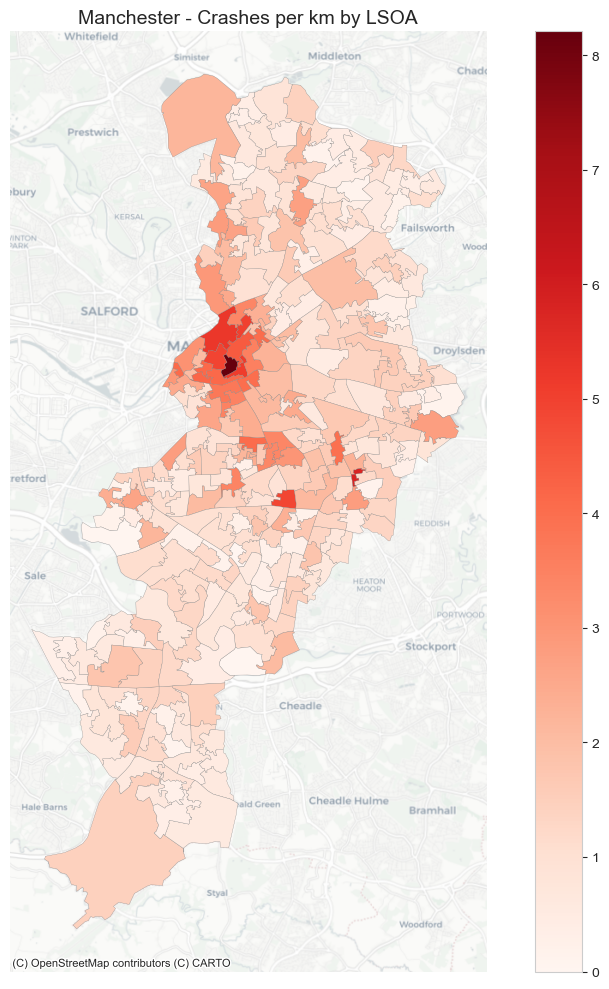

In [297]:
# manchester - crashes per km
fig, ax = plt.subplots(figsize=(10, 10))

man_map.plot(
    column="crashes_per_km",
    cmap="Reds",
    legend=True,
    edgecolor="grey",
    linewidth=0.2,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=man_map.crs)

ax.set_title("Manchester - Crashes per km by LSOA", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

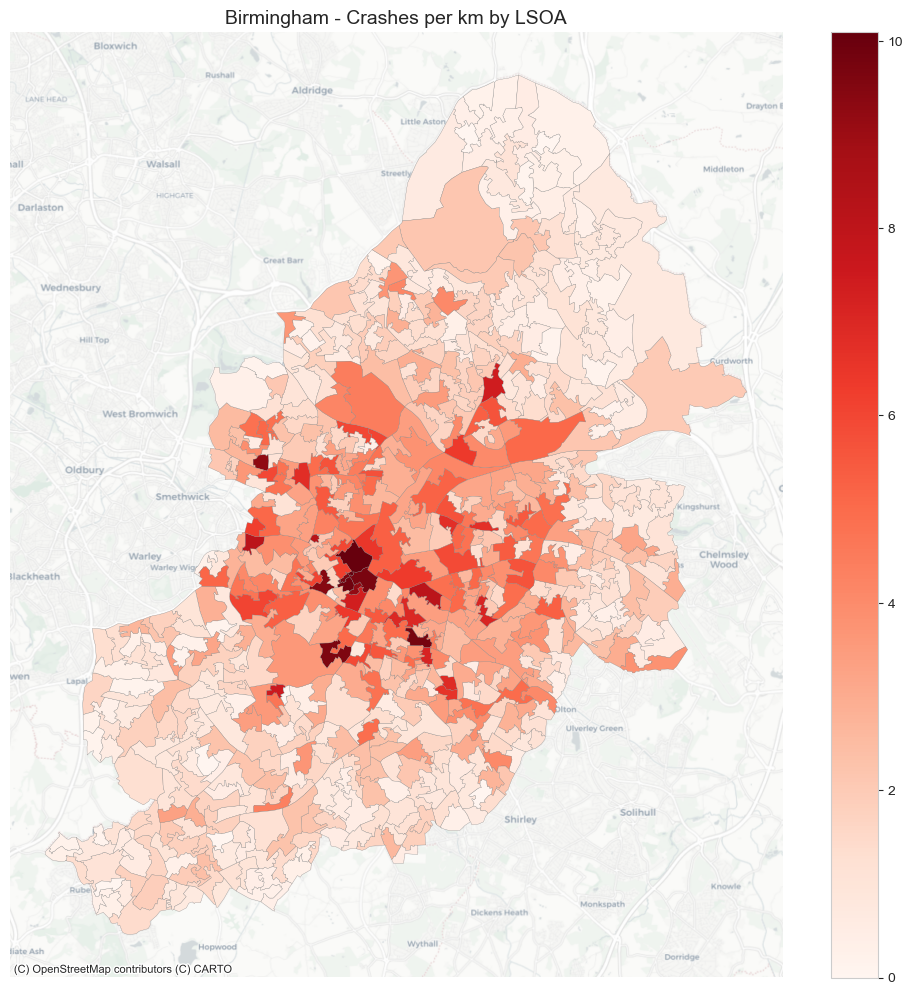

In [298]:
# birmingham - crashes per km
fig, ax = plt.subplots(figsize=(10, 10))

bir_map.plot(
    column="crashes_per_km",
    cmap="Reds",
    legend=True,
    edgecolor="grey",
    linewidth=0.2,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=bir_map.crs)

ax.set_title("Birmingham - Crashes per km by LSOA", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

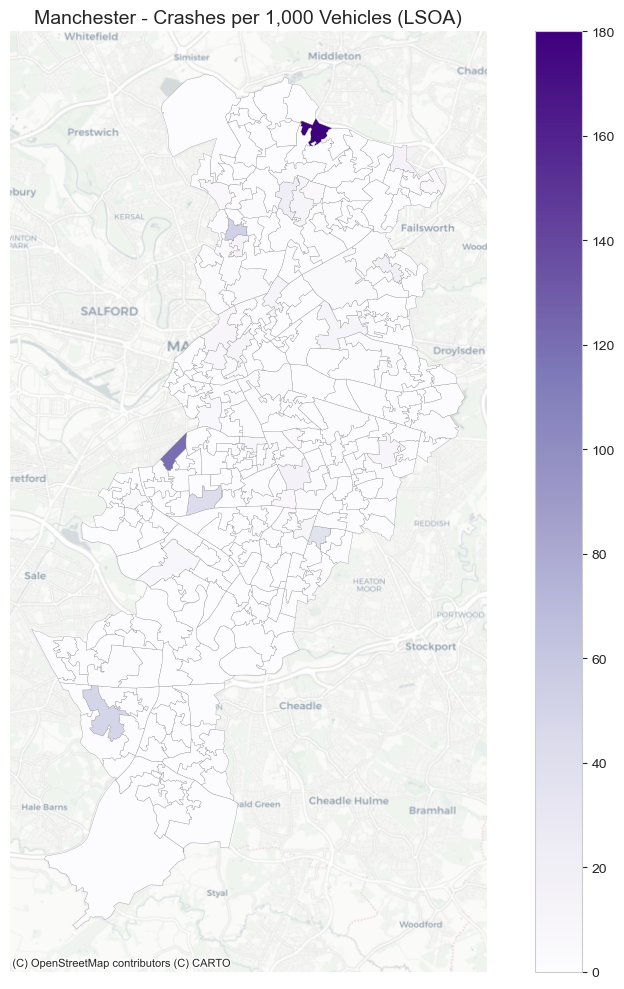

In [303]:
# manchester - crashes per 1000 vehicles
fig, ax = plt.subplots(figsize=(10, 10))

man_map.plot(
    column="crashes_per_1000_vehicles_imputed",
    cmap="Purples",
    legend=True,
    edgecolor="grey",
    linewidth=0.2,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=man_map.crs)

ax.set_title("Manchester - Crashes per 1,000 Vehicles (LSOA)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

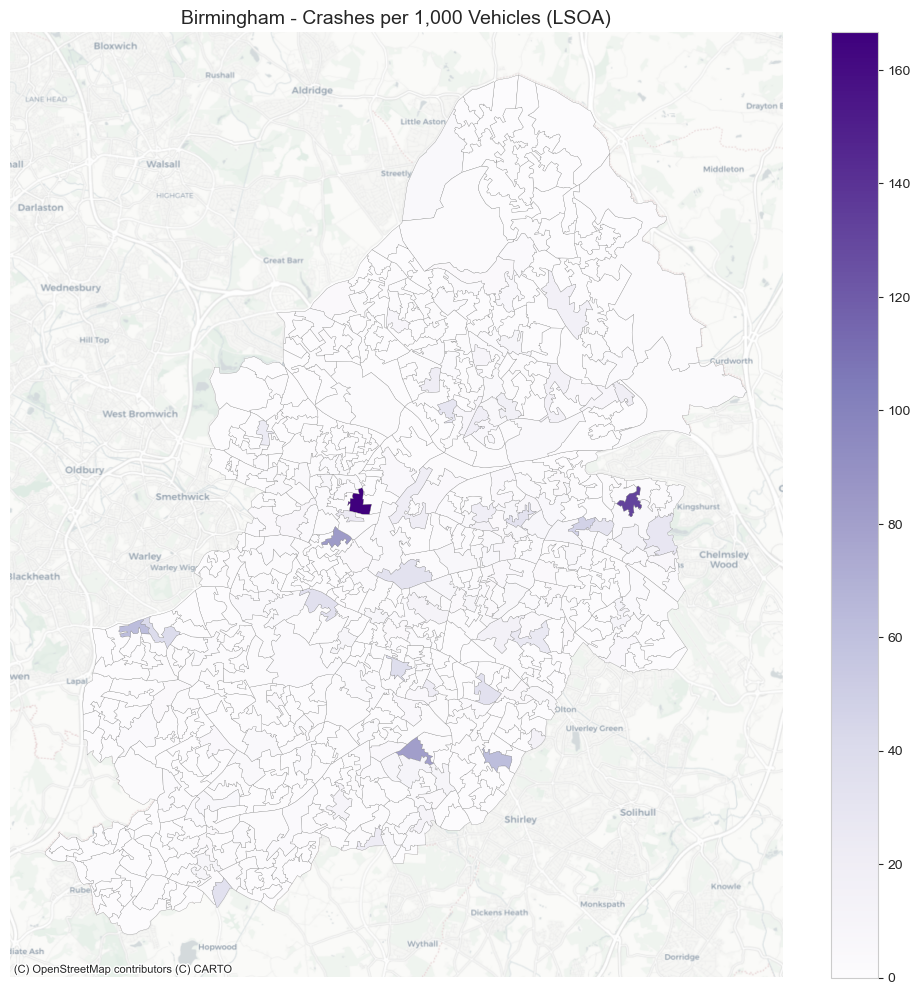

In [305]:
# birmingham- crashes per 1000 vehicles
fig, ax = plt.subplots(figsize=(10, 10))

bir_map.plot(
    column="crashes_per_1000_vehicles_imputed",
    cmap="Purples",
    legend=True,
    edgecolor="grey",
    linewidth=0.2,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=man_map.crs)

ax.set_title("Birmingham - Crashes per 1,000 Vehicles (LSOA)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In [307]:
# t test

In [309]:
man_data = final_data[final_data["city"] == "Manchester"]
bir_data = final_data[final_data["city"] == "Birmingham"]

# crashes per km
t_km, p_km = ttest_ind(
    man_data["crashes_per_km"].dropna(),
    bir_data["crashes_per_km"].dropna(),
    equal_var=False  # Welch’s t-test (recommended if variances differ)
)


# crashes per 1000 vehicles
t_veh, p_veh = ttest_ind(
    man_data["crashes_per_1000_vehicles_imputed"].dropna(),
    bir_data["crashes_per_1000_vehicles_imputed"].dropna(),
    equal_var=False
)

print(f"Crashes per km — t = {round(t_km, 3)}, p = {round(p_km, 4)}")
print(f"Crashes per 1,000 vehicles — t = {round(t_veh, 3)}, p = {round(p_veh, 4)}")

Crashes per km — t = -9.344, p = 0.0
Crashes per 1,000 vehicles — t = -0.587, p = 0.5577


In [311]:
# Mann-Whitney U Test

In [312]:
stat, p = mannwhitneyu(
    man_data["crashes_per_km"].dropna(),
    bir_data["crashes_per_km"].dropna(),
    alternative="two-sided"
)
print(f"Mann-Whitney U test for crashes_per_km: stat={stat}, p={p}")
stat, p = mannwhitneyu(
    man_data["crashes_per_1000_vehicles_imputed"].dropna(),
    bir_data["crashes_per_1000_vehicles_imputed"].dropna(),
    alternative="two-sided"
)
print(f"Mann-Whitney U test for crashes_per_1000_vehicles: stat={stat}, p={p}")

Mann-Whitney U test for crashes_per_km: stat=66748.5, p=9.75974913006048e-15
Mann-Whitney U test for crashes_per_1000_vehicles: stat=71787.0, p=1.0374933277199048e-10


In [315]:
# correlation test - road length and crashes per km

In [317]:
x = final_data["road_length"]
y = final_data["crashes_per_km"]

corr_p, p = pearsonr(x.dropna(), y.dropna())
print(f"Pearson correlation (road length vs crashes/km): r = {round(corr_p, 3)}, p = {round(p, 4)}")
corr_s, s = spearmanr(x, y)
print(f"Spearman correlation (road length vs crashes/km): r = {round(corr_s, 3)}, p = {round(s, 4)}")

Pearson correlation (road length vs crashes/km): r = -0.108, p = 0.0009
Spearman correlation (road length vs crashes/km): r = -0.167, p = 0.0


In [319]:
# correlation test - traffic volume and crashes per 1000 vehicles

In [321]:
x = final_data["avg_daily_traffic_idw"]
y = final_data["crashes_per_1000_vehicles_imputed"]

corr, p = pearsonr(x.dropna(), y.dropna())
print(f"Pearson correlation (traffic vs crashes/1000 vehicles): r = {round(corr, 3)}, p = {round(p, 4)}")
corr_s, s = spearmanr(x, y)
print(f"Spearman correlation (road length vs crashes/km): r = {round(corr_s, 3)}, p = {round(s, 4)}")

Pearson correlation (traffic vs crashes/1000 vehicles): r = -0.198, p = 0.0
Spearman correlation (road length vs crashes/km): r = -0.574, p = 0.0


In [324]:
##### OBJECTIVE 4 #####

In [327]:
### XGBOOST ###

In [329]:
# overall predictive model

In [331]:
model_data = final_data.copy()
threshold = model_data["crashes_per_km"].quantile(0.75)
model_data["high_risk"] = (model_data["crashes_per_km"] >= threshold).astype(int)

features = [
    "road_length",
    "avg_daily_traffic_idw",
    "temperature_2m",
    "precipitation",
    "wind_speed_10m",
    "relative_humidity_2m"
]
X = model_data[features].fillna(0)
y = model_data["high_risk"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
model.fit(X_train, y_train)

C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:01:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [333]:
# evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       179
           1       0.65      0.50      0.57        60

    accuracy                           0.81       239
   macro avg       0.75      0.71      0.72       239
weighted avg       0.80      0.81      0.80       239

ROC AUC Score: 0.8160148975791434
Confusion Matrix:
[[163  16]
 [ 30  30]]


In [335]:
features = [
    "avg_daily_traffic_idw",                           
    "avg_severity",                     
    "crashes_per_1000_vehicles_imputed",  
    "temperature_2m",
    "precipitation",
    "snowfall",
    "wind_speed_10m",
    "cloud_cover_low",
    "relative_humidity_2m"
]

In [337]:
X = model_data[features].fillna(0)
y = model_data["high_risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# scale_pos_weight
from collections import Counter
class_counts = Counter(y_train)
scale = class_counts[0] / class_counts[1]
print("scale_pos_weight:", round(scale, 2))

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [scale],  # keep fixed for now
}

# base model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# grid search
grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

# overal optimal predictive model
optimal_model = grid.best_estimator_
print("\n Parameters:", grid.best_params_)

scale_pos_weight: 2.99
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:03:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'scale_pos_weight': 2.994413407821229, 'subsample': 0.8}


In [338]:
# evaluate
# Predict classes and probabilities
y_pred = optimal_model.predict(X_test)
y_proba = optimal_model.predict_proba(X_test)[:, 1]

# 1. Classification metrics
print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred))

# 2. Confusion matrix
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 3. ROC AUC
auc_score = roc_auc_score(y_test, y_proba)
print("🎯 ROC AUC Score:", round(auc_score, 3))


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       179
           1       0.82      0.78      0.80        60

    accuracy                           0.90       239
   macro avg       0.88      0.86      0.87       239
weighted avg       0.90      0.90      0.90       239

📊 Confusion Matrix:
[[169  10]
 [ 13  47]]
🎯 ROC AUC Score: 0.953


In [341]:
# cross city

In [343]:
man_data = model_data[model_data["city"] == "Manchester"]
bir_data = model_data[model_data["city"] == "Birmingham"]
features = [
    "avg_daily_traffic_idw", "avg_severity",
    "crashes_per_1000_vehicles_imputed", "temperature_2m", "precipitation",
    "snowfall", "wind_speed_10m", "cloud_cover_low", "relative_humidity_2m"
]

X_man = man_data[features].fillna(0)
y_man = man_data["high_risk"]

X_bir = bir_data[features].fillna(0)
y_bir = bir_data["high_risk"]

In [345]:
# Manchester
X_man_train, X_man_test, y_man_train, y_man_test = train_test_split(X_man, y_man, stratify=y_man, test_size=0.25, random_state=42)
scale_man = Counter(y_man_train)[0] / Counter(y_man_train)[1]

model_man = XGBClassifier(scale_pos_weight=scale_man, use_label_encoder=False, eval_metric='logloss', random_state=42)
model_man.fit(X_man_train, y_man_train)
y_man_pred = model_man.predict(X_man_test)
y_man_proba = model_man.predict_proba(X_man_test)[:, 1]

print("🔵 Manchester Model")
print(classification_report(y_man_test, y_man_pred))
print("ROC AUC:", roc_auc_score(y_man_test, y_man_proba))
print("Confusion Matrix:", confusion_matrix(y_man_test, y_man_pred))

C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:04:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔵 Manchester Model
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        66
           1       0.33      0.25      0.29         8

    accuracy                           0.86        74
   macro avg       0.62      0.59      0.61        74
weighted avg       0.85      0.86      0.86        74

ROC AUC: 0.9034090909090908
Confusion Matrix: [[62  4]
 [ 6  2]]


In [347]:
# Birmingham
X_bir_train, X_bir_test, y_bir_train, y_bir_test = train_test_split(X_bir, y_bir, stratify=y_bir, test_size=0.25, random_state=42)
scale_bir = Counter(y_bir_train)[0] / Counter(y_bir_train)[1]

model_bir = XGBClassifier(scale_pos_weight=scale_bir, use_label_encoder=False, eval_metric='logloss', random_state=42)
model_bir.fit(X_bir_train, y_bir_train)
y_bir_pred = model_bir.predict(X_bir_test)
y_bir_proba = model_bir.predict_proba(X_bir_test)[:, 1]

print("\n🟢 Birmingham Model")
print(classification_report(y_bir_test, y_bir_pred))
print("ROC AUC:", roc_auc_score(y_bir_test, y_bir_proba))
print("Confusion Matrix:", confusion_matrix(y_bir_test, y_bir_pred))

C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:04:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🟢 Birmingham Model
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       113
           1       0.85      0.67      0.75        52

    accuracy                           0.86       165
   macro avg       0.86      0.81      0.83       165
weighted avg       0.86      0.86      0.86       165

ROC AUC: 0.9166099387338325
Confusion Matrix: [[107   6]
 [ 17  35]]


In [349]:
# cross evaluation

In [351]:
# Manchester model applied to Birmingham
y_bir_from_man = model_man.predict(X_bir_test)
print("\n🔄 Manchester model tested on Birmingham")
print(classification_report(y_bir_test, y_bir_from_man))


🔄 Manchester model tested on Birmingham
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       113
           1       0.71      0.29      0.41        52

    accuracy                           0.74       165
   macro avg       0.73      0.62      0.62       165
weighted avg       0.73      0.74      0.70       165



In [353]:
# Birmingham model applied to Manchester
y_man_from_bir = model_bir.predict(X_man_test)
print("\n🔄 Birmingham model tested on Manchester")
print(classification_report(y_man_test, y_man_from_bir))


🔄 Birmingham model tested on Manchester
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        66
           1       0.50      0.75      0.60         8

    accuracy                           0.89        74
   macro avg       0.73      0.83      0.77        74
weighted avg       0.92      0.89      0.90        74



In [355]:
# training the full model data and testing it on manchester and birmingham

In [359]:
# testing the full model on Manchester
man_data = model_data[model_data["city"] == "Manchester"]
X_man = man_data[features].fillna(0)
y_man = man_data["high_risk"]

y_man_pred = optimal_model.predict(X_man)
y_man_proba = optimal_model.predict_proba(X_man)[:, 1]

print("🔵 Manchester Evaluation")
print(classification_report(y_man, y_man_pred))
print("ROC AUC:", roc_auc_score(y_man, y_man_proba))
print("Confusion Matrix:\n", confusion_matrix(y_man, y_man_pred))

🔵 Manchester Evaluation
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       265
           1       0.90      0.93      0.92        30

    accuracy                           0.98       295
   macro avg       0.95      0.96      0.95       295
weighted avg       0.98      0.98      0.98       295

ROC AUC: 0.9944654088050314
Confusion Matrix:
 [[262   3]
 [  2  28]]


In [361]:
# testing the full model on Birmingham
bir_data = model_data[model_data["city"] == "Birmingham"]
X_bir = bir_data[features].fillna(0)
y_bir = bir_data["high_risk"]

y_bir_pred = optimal_model.predict(X_bir)
y_bir_proba = optimal_model.predict_proba(X_bir)[:, 1]

print("\n🟢 Birmingham Evaluation")
print(classification_report(y_bir, y_bir_pred))
print("ROC AUC:", roc_auc_score(y_bir, y_bir_proba))
print("Confusion Matrix:\n", confusion_matrix(y_bir, y_bir_pred))


🟢 Birmingham Evaluation
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       450
           1       0.97      0.95      0.96       209

    accuracy                           0.97       659
   macro avg       0.97      0.97      0.97       659
weighted avg       0.97      0.97      0.97       659

ROC AUC: 0.9942796384901648
Confusion Matrix:
 [[443   7]
 [ 11 198]]
